# **Market Timing Strategies using Kalman Filter**

*WorldQuant University, MSc Financial Engineering*

*author: rakeshsharma.pr@gmail.com*


# **Introduction**

In this section, I will explore the implementation of a Kalman filter in Python using the library Pykalman. Later on I will use the Kalman Filter created to forecast stock prices. The 2 stocks we are targeting are Ethereum and Bitcoin. The reason for chosing these assets for this project is the due to the high volatility of the Crypto data, they are also noisy. Kalman filter stands out as an ideal method for such data. As discussed in the literature review, research shows that Kalman filters have better outcomes for time series forecasting and can be used with various pricing algorithms, such as Heston, Bates etc. The update method of the filter can be used for real time price updates which might be needed for aggressive trading strategies.

In [67]:
# installation of libraries
!pip install -U vectorbt
!pip install pykalman
!pip install plotly
!pip install statsmodels
!pip install numpy
!pip install yfinance

In [68]:
# importing of libraries

import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm

# **Exploratory Data Analysis**

We will extracting the Crypto Data BTC-USD and ETH-USD from yahoo.com.
Python provides a seamless library to extract the data

In [71]:
# crypto currencies of interest - Bitcoin and Ethereum
stock_list = ['BTC-USD', 'ETH-USD']

In [72]:
# extracting the stock price for the last 2 years
data = yf.download(stock_list, start='2022-09-01', end='2024-08-31')
data.head()

[*********************100%***********************]  2 of 2 completed


Price                         Adj Close                      Close  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2022-09-01 00:00:00+00:00  20127.140625  1586.176758  20127.140625   
2022-09-02 00:00:00+00:00  19969.771484  1577.220459  19969.771484   
2022-09-03 00:00:00+00:00  19832.087891  1556.872681  19832.087891   
2022-09-04 00:00:00+00:00  19986.712891  1577.641602  19986.712891   
2022-09-05 00:00:00+00:00  19812.371094  1617.183228  19812.371094   

Price                                           High               \
Ticker                         ETH-USD       BTC-USD      ETH-USD   
Date                                                                
2022-09-01 00:00:00+00:00  1586.176758  20198.390625  1593.082764   
2022-09-02 00:00:00+00:00  1577.220459  20401.568359  1643.183228   
2022-09-03 00:00:00+00:00  1556.872681  20037.009766  1579.454346   
2022-09-04 00:00:00+00:00  1577.641602  19999.689453  1578.009277   
2022-09-05 00:00:00+00:00  1617.183228  20031.160156  1621.661377   

Price                               Low                       Open  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2022-09-01 00:00:00+00:00  19653.968750  1520.188354  20050.498047   
2022-09-02 00:00:00+00:00  19814.765625  1551.877930  20126.072266   
2022-09-03 00:00:00+00:00  19698.355469  1541.672119  19969.718750   
2022-09-04 00:00:00+00:00  19636.816406  1543.698853  19832.470703   
2022-09-05 00:00:00+00:00  19673.046875  1559.781860  19988.789062   

Price                                        Volume               
Ticker                         ETH-USD      BTC-USD      ETH-USD  
Date                                                              
2022-09-01 00:00:00+00:00  1553.756348  30182031010  16434276817  
2022-09-02 00:00:00+00:00  1586.017944  29123998928  17708478709  
2022-09-03 00:00:00+00:00  1577.213745  23613051457   9516825994  
2022-09-04 00:00:00+00:00  1556.895874  25245861652   8884144998  
2022-09-05 00:00:00+00:00  1577.884033  28813460025  13060541168

**Understanding distribution of Data & Correlation**

In [74]:
data.describe()

Price      Adj Close                      Close                       High  \
Ticker       BTC-USD      ETH-USD       BTC-USD      ETH-USD       BTC-USD   
count     730.000000   730.000000    730.000000   730.000000    730.000000   
mean    37518.319863  2154.649833  37518.319863  2154.649833  38162.137949   
std     17685.270401   760.858790  17685.270401   760.858790  18083.910703   
min     15787.284180  1100.169800  15787.284180  1100.169800  16253.047852   
25%     23665.855469  1620.496521  23665.855469  1620.496521  24119.581543   
50%     29412.204102  1866.100159  29412.204102  1866.100159  29845.836914   
75%     55988.014648  2640.965576  55988.014648  2640.965576  57679.622070   
max     73083.500000  4066.445068  73083.500000  4066.445068  73750.070312   

Price                         Low                       Open               \
Ticker      ETH-USD       BTC-USD      ETH-USD       BTC-USD      ETH-USD   
count    730.000000    730.000000   730.000000    730.000000   730.000000   
mean    2197.880829  36780.942348  2107.257615  37464.146091  2153.339377   
std      781.196683  17220.739292   736.665024  17678.426052   761.057358   
min     1136.442627  15599.046875  1081.138184  15782.300781  1100.107178   
25%     1644.864014  23253.754883  1580.678528  23627.717285  1617.854645   
50%     1887.949524  29113.966797  1845.784241  29403.917969  1865.844604   
75%     2709.429199  54234.083008  2585.498413  55644.687500  2640.590576   
max     4092.284180  71334.093750  3936.627197  73079.375000  4066.690430   

Price         Volume                
Ticker       BTC-USD       ETH-USD  
count   7.300000e+02  7.300000e+02  
mean    2.494924e+10  1.111478e+10  
std     1.410581e+10  6.917282e+09  
min     5.331173e+09  2.081626e+09  
25%     1.473525e+10  6.289494e+09  
50%     2.165289e+10  9.412596e+09  
75%     3.145988e+10  1.414162e+10  
max     1.189925e+11  6.766813e+10

The data shows that open, close, High,low are correlated, we can check this in our plot

In [76]:
data.corr().style.background_gradient(cmap='coolwarm')

In [77]:
data.isnull().any()

Price      Ticker 
Adj Close  BTC-USD    False
           ETH-USD    False
Close      BTC-USD    False
           ETH-USD    False
High       BTC-USD    False
           ETH-USD    False
Low        BTC-USD    False
           ETH-USD    False
Open       BTC-USD    False
           ETH-USD    False
Volume     BTC-USD    False
           ETH-USD    False
dtype: bool

The dataset do not contain any null values

In [79]:
closing_data = data['Adj Close']['BTC-USD']
closing_data.head()

Date
2022-09-01 00:00:00+00:00    20127.140625
2022-09-02 00:00:00+00:00    19969.771484
2022-09-03 00:00:00+00:00    19832.087891
2022-09-04 00:00:00+00:00    19986.712891
2022-09-05 00:00:00+00:00    19812.371094
Name: BTC-USD, dtype: float64

In [80]:
closing_data = data['Adj Close']['ETH-USD']
closing_data.head()

Date
2022-09-01 00:00:00+00:00    1586.176758
2022-09-02 00:00:00+00:00    1577.220459
2022-09-03 00:00:00+00:00    1556.872681
2022-09-04 00:00:00+00:00    1577.641602
2022-09-05 00:00:00+00:00    1617.183228
Name: ETH-USD, dtype: float64

**Trend, Noise, Seasonality - Decoding**

Checking the underlying trend for BTC and ETH

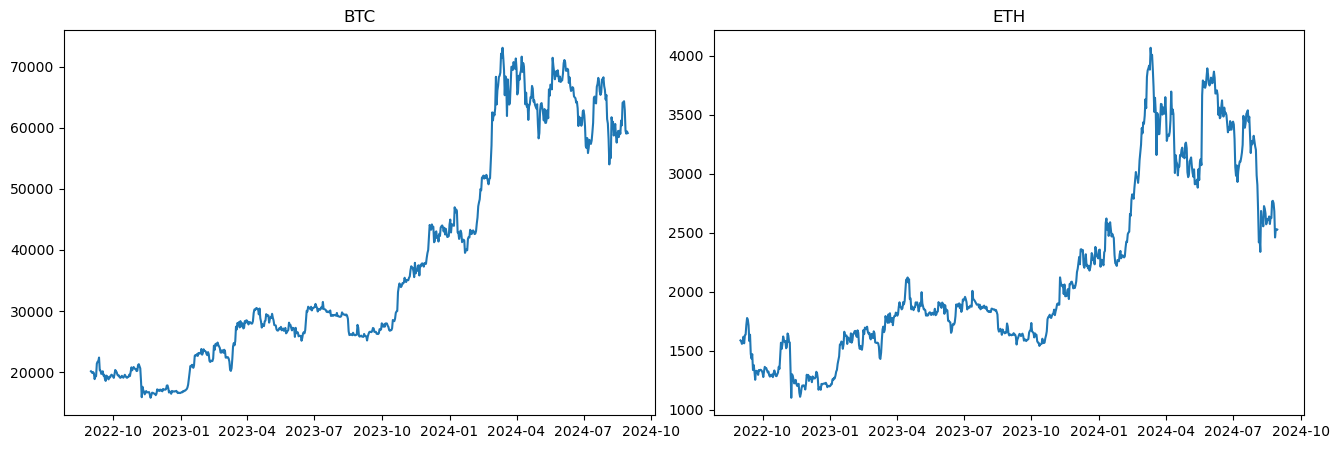

In [83]:
fig, axs =plt.subplots(1,2,figsize=(16, 5),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0].plot(data['Adj Close']['BTC-USD'])
axs[0].set_title('BTC')
axs[1].plot(data['Adj Close']['ETH-USD'])
axs[1].set_title('ETH')
plt.show()

Lets Visualize the Volume for trend, noise and seasonality

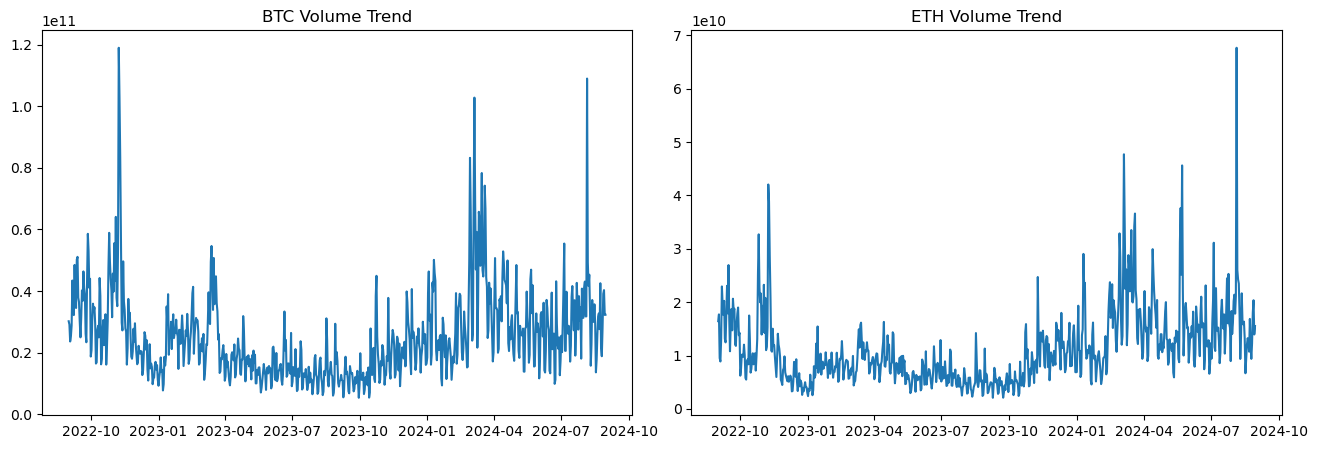

In [85]:
fig, axs =plt.subplots(1,2,figsize=(16, 5),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0].plot(data['Volume']['BTC-USD'])
axs[0].set_title('BTC Volume Trend')
axs[1].plot(data['Volume']['ETH-USD'])
axs[1].set_title('ETH Volume Trend')
plt.show()

Taking the first differential to remove the noise

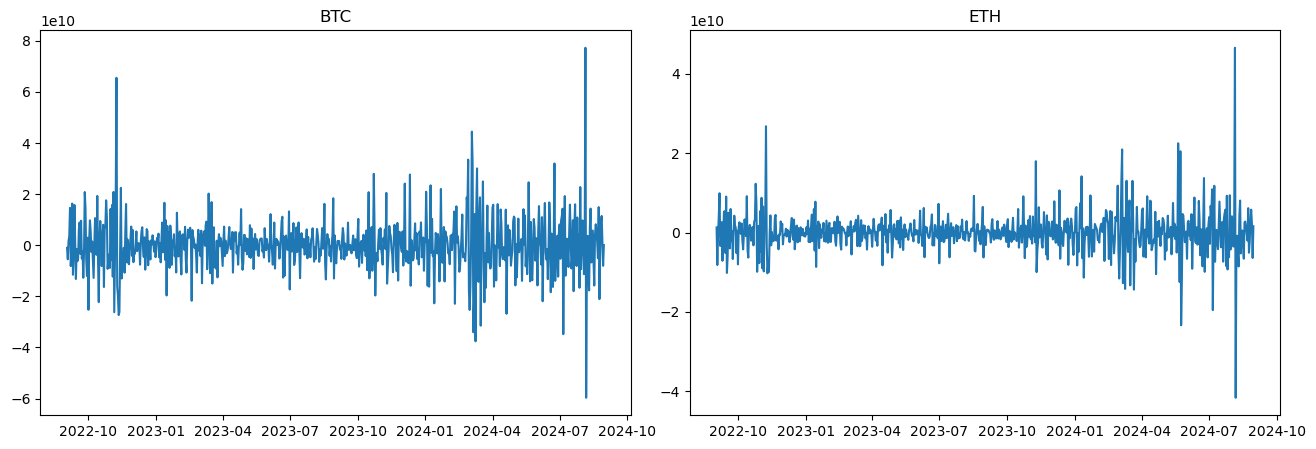

In [87]:
fig, axs =plt.subplots(1,2,figsize=(16, 5),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0].plot(data['Volume']['BTC-USD'].diff())
axs[0].set_title('BTC')
axs[1].plot(data['Volume']['ETH-USD'].diff())
axs[1].set_title('ETH')
plt.show()

Even after taking the first differrence we can see the volatility, in the below section we will take a second difference, but we can see that there is still there is lot of ups and downs in the trendline

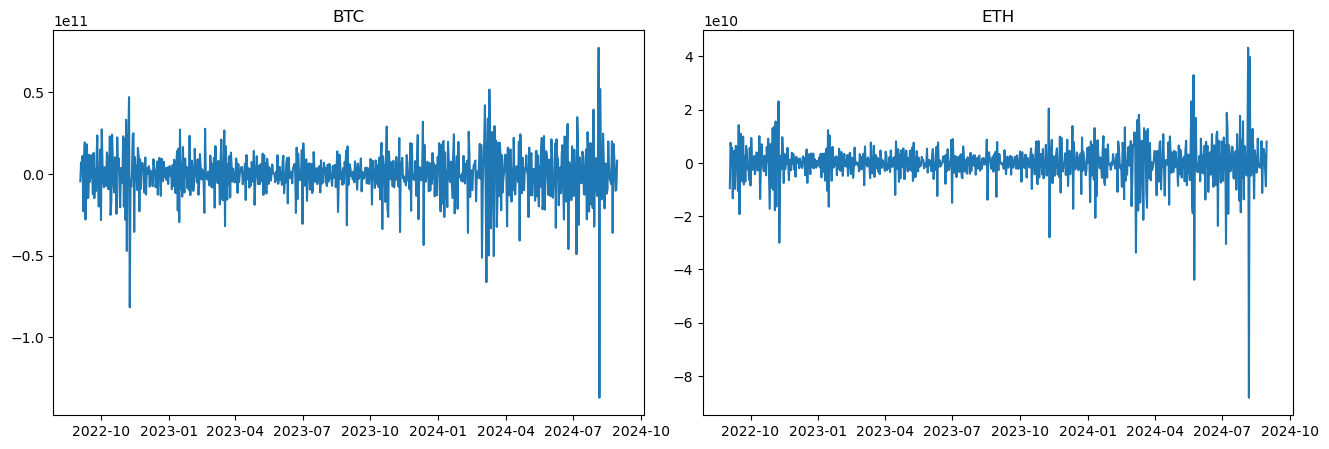

In [89]:
fig, axs =plt.subplots(1,2,figsize=(16, 5),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
axs[0].plot(data['Volume']['BTC-USD'].diff().diff())
axs[0].set_title('BTC')
axs[1].plot(data['Volume']['ETH-USD'].diff().diff())
axs[1].set_title('ETH')
plt.show()

Let us plot percentage change to understand the mean reversion in the data. The changes are within the range -10 to +10 % for BTC data. For ETH the percentage chnage is more around 20% and upside volatility is more than the downside as downsides are within the range of -10 for most of the time.

(-0.5, 0.5)

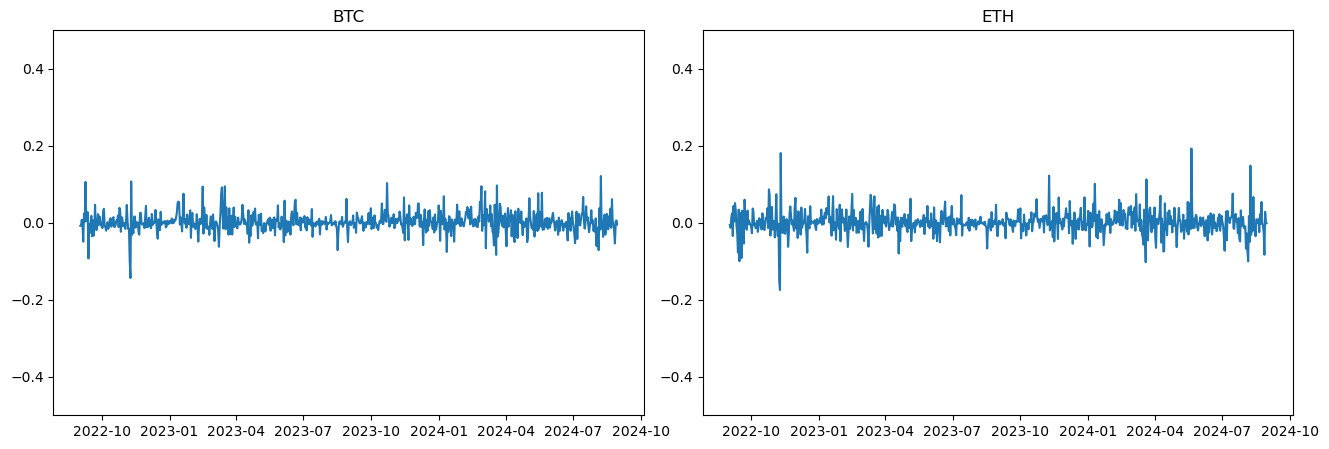

In [91]:

fig, axs = plt.subplots(1,2,figsize=(16,5),gridspec_kw ={'hspace': 0.2, 'wspace': 0.1})
btc = data['Adj Close']['BTC-USD'].pct_change().dropna(axis=0)
axs[0].plot(btc)
axs[0].set_title('BTC')
axs[0].set_ylim([-0.5,0.5])

eth = data['Adj Close']['ETH-USD'].pct_change().dropna(axis=0)
axs[1].plot(eth)
axs[1].set_title('ETH')
axs[1].set_ylim([-0.5,0.5])

**OHLC plots - Understanding Price movements**
A candle stick plot helps us understand the spread between the prices of the crypto currency from the opening and closing price and identity the periods where they were coninuously on the rise.

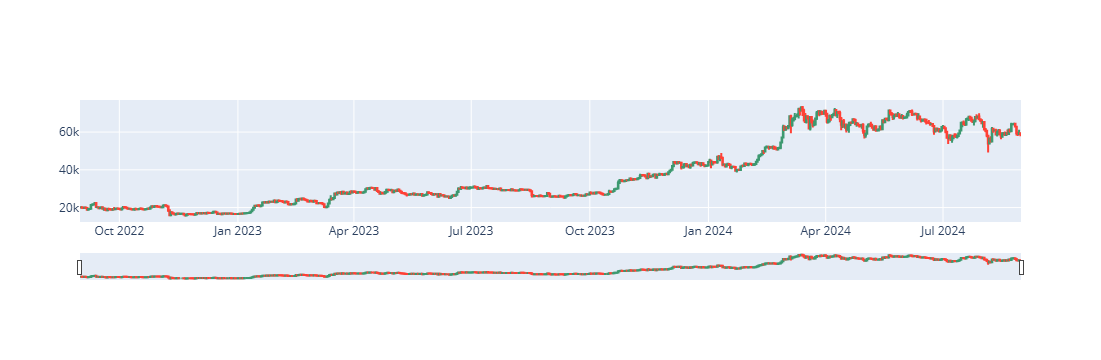

In [93]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open']['BTC-USD'], high=data['High']['BTC-USD'],
                low=data['Low']['BTC-USD'], close=data['Close']['BTC-USD'])
                     ])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

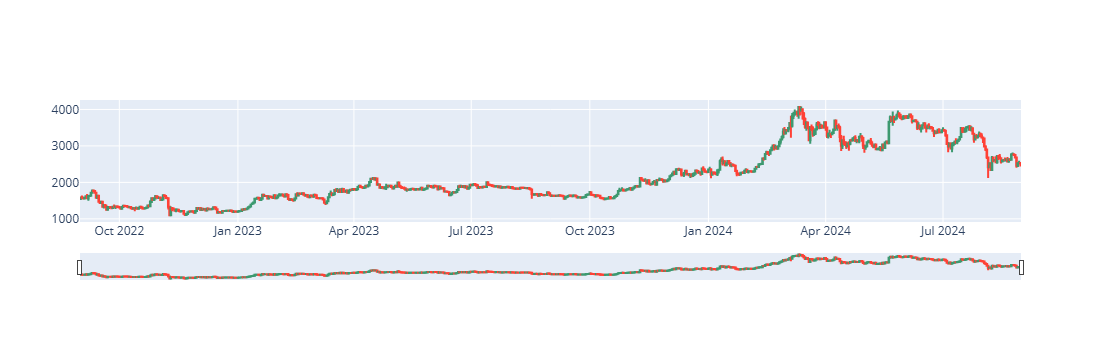

In [94]:
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open']['ETH-USD'], high=data['High']['ETH-USD'],
                low=data['Low']['ETH-USD'], close=data['Close']['ETH-USD'])
                     ])
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

**Understanding the Price shocks**

We can see how the rolling mean for various intervals looks like for our crypto data, we find that with increasing window size our data gets smoother and allows us to see the trend over which can be used for generating feature engineering. The shorter the window closer it is to the actual stock price and considers the price shocks.

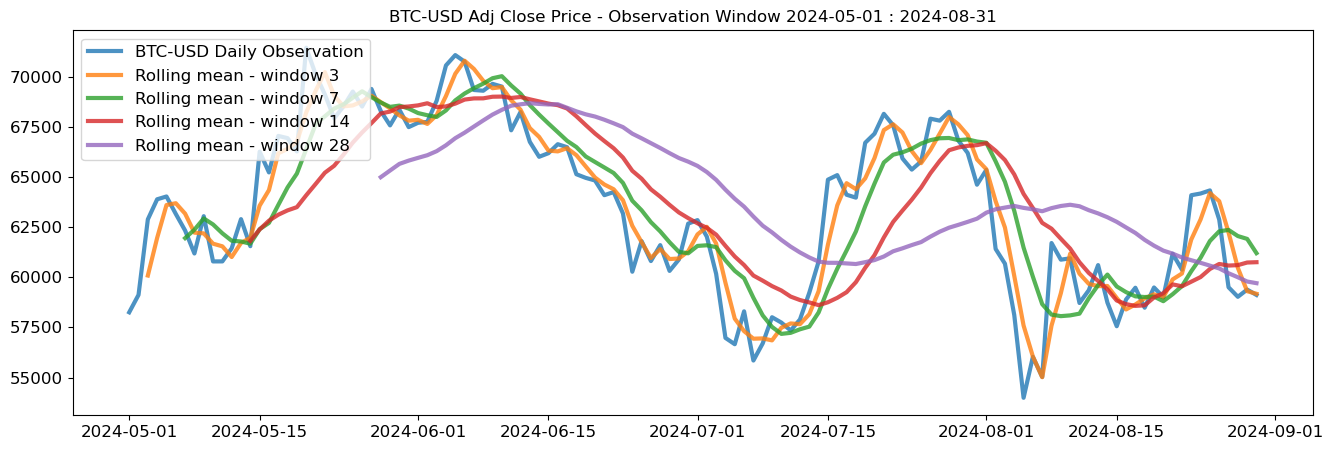

In [97]:
btc_closing_data = data['Adj Close']['BTC-USD'].loc['2024-05-01':'2024-09-01']
rolling_3d = btc_closing_data.rolling(window=3).mean()
rolling_7d = btc_closing_data.rolling(window=7).mean()
rolling_14d = btc_closing_data.rolling(window=14).mean()
rolling_28d = btc_closing_data.rolling(window=28).mean()


plt.figure(figsize=(16, 5))
plt.plot(btc_closing_data.index, btc_closing_data, lw=3, alpha=0.8, label='BTC-USD Daily Observation')
plt.plot(btc_closing_data.index, rolling_3d, lw=3, alpha=0.8,label='Rolling mean - window 3')
plt.plot(btc_closing_data.index, rolling_7d, lw=3, alpha=0.8,label='Rolling mean - window 7')
plt.plot(btc_closing_data.index, rolling_14d, lw=3, alpha=0.8,label='Rolling mean - window 14')
plt.plot(btc_closing_data.index, rolling_28d, lw=3, alpha=0.8,label='Rolling mean - window 28')

plt.title('BTC-USD Adj Close Price - Observation Window 2024-05-01 : 2024-08-31')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

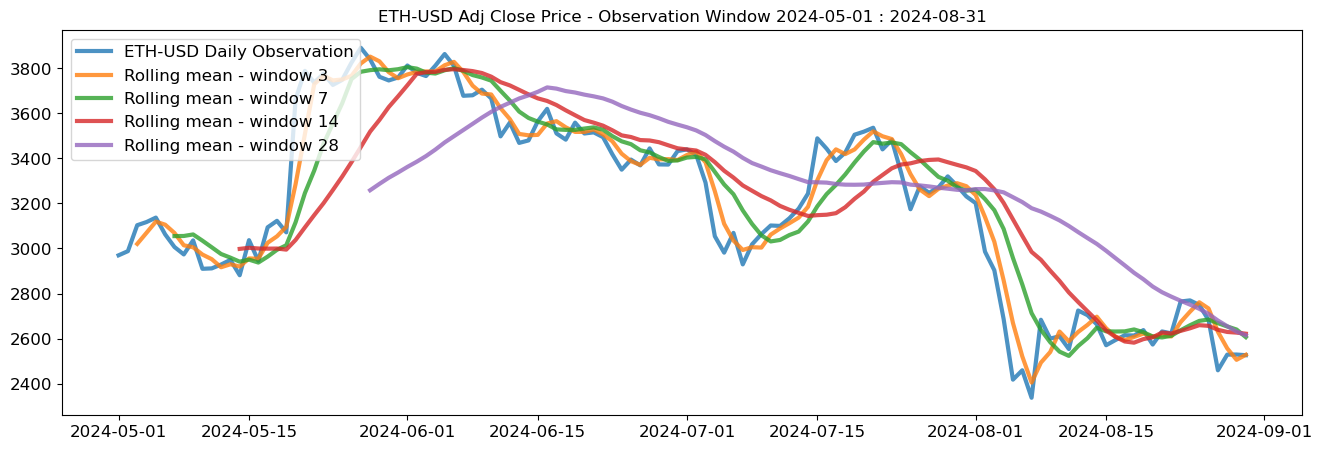

In [98]:
eth_closing_data = data['Adj Close']['ETH-USD'].loc['2024-05-01':'2024-08-31']
rolling_3d = eth_closing_data.rolling(window=3).mean()
rolling_7d = eth_closing_data.rolling(window=7).mean()
rolling_14d = eth_closing_data.rolling(window=14).mean()
rolling_28d = eth_closing_data.rolling(window=28).mean()


plt.figure(figsize=(16, 5))
plt.plot(eth_closing_data.index, eth_closing_data, lw=3, alpha=0.8, label='ETH-USD Daily Observation')
plt.plot(eth_closing_data.index, rolling_3d, lw=3, alpha=0.8,label='Rolling mean - window 3')
plt.plot(eth_closing_data.index, rolling_7d, lw=3, alpha=0.8,label='Rolling mean - window 7')
plt.plot(eth_closing_data.index, rolling_14d, lw=3, alpha=0.8,label='Rolling mean - window 14')
plt.plot(eth_closing_data.index, rolling_28d, lw=3, alpha=0.8,label='Rolling mean - window 28')

plt.title('ETH-USD Adj Close Price - Observation Window 2024-05-01 : 2024-08-31')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

Ethereum rolling means are lot steeper than BTC, in the further sections we will do the causality tests to see autocorrelation.

**Understanding the Volume Shocks**

Positive volume shocks can be leveraged to improve returns and it is signifcant for volume based trading in crypto. Trading strategists can buy stocks on a positive volume jump and sell stocks on volume downsides to make profit over a period of time. A shock is defined as the increase or decrease in the volume comapred to the 12-month average.
Compared to the rolling mean for 28 days, daily volume shows significant upward spikes compared to downfalls.

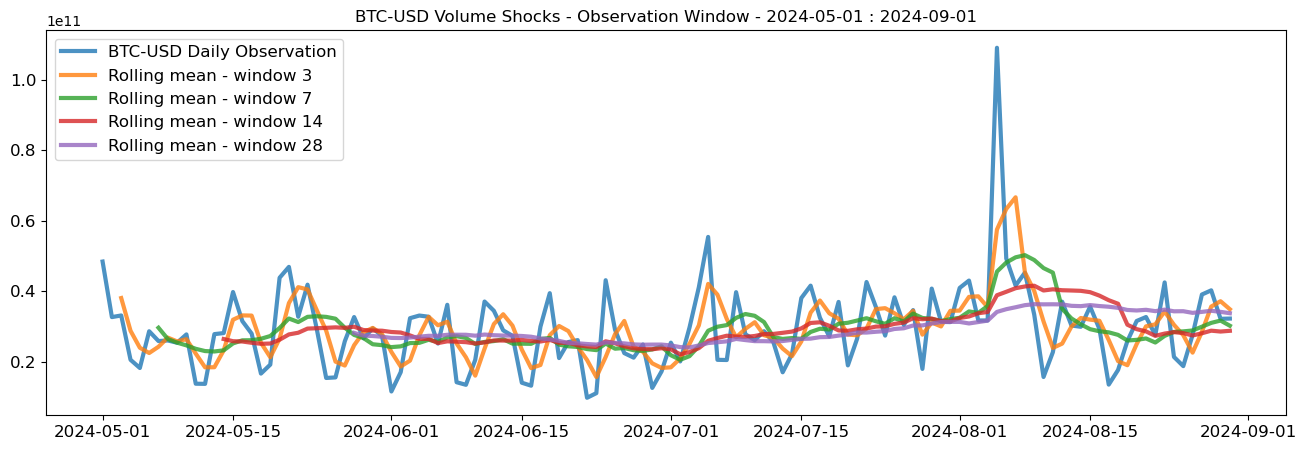

In [101]:
btc_closing_data = data['Volume']['BTC-USD'].loc['2024-05-01':'2024-09-01']
rolling_3d = btc_closing_data.rolling(window=3).mean()
rolling_7d = btc_closing_data.rolling(window=7).mean()
rolling_14d = btc_closing_data.rolling(window=14).mean()
rolling_28d = btc_closing_data.rolling(window=28).mean()


plt.figure(figsize=(16, 5))
plt.plot(btc_closing_data.index, btc_closing_data, lw=3, alpha=0.8, label='BTC-USD Daily Observation')
plt.plot(btc_closing_data.index, rolling_3d, lw=3, alpha=0.8,label='Rolling mean - window 3')
plt.plot(btc_closing_data.index, rolling_7d, lw=3, alpha=0.8,label='Rolling mean - window 7')
plt.plot(btc_closing_data.index, rolling_14d, lw=3, alpha=0.8,label='Rolling mean - window 14')
plt.plot(btc_closing_data.index, rolling_28d, lw=3, alpha=0.8,label='Rolling mean - window 28')

plt.title('BTC-USD Volume Shocks - Observation Window - 2024-05-01 : 2024-09-01')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

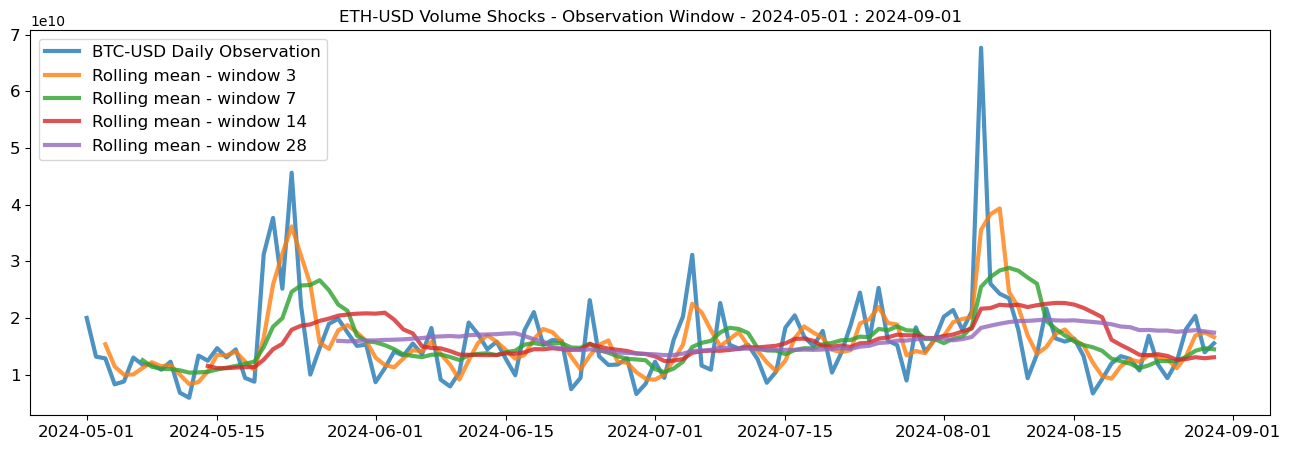

In [102]:
btc_closing_data = data['Volume']['ETH-USD'].loc['2024-05-01':'2024-09-01']
rolling_3d = btc_closing_data.rolling(window=3).mean()
rolling_7d = btc_closing_data.rolling(window=7).mean()
rolling_14d = btc_closing_data.rolling(window=14).mean()
rolling_28d = btc_closing_data.rolling(window=28).mean()


plt.figure(figsize=(16, 5))
plt.plot(btc_closing_data.index, btc_closing_data, lw=3, alpha=0.8, label='BTC-USD Daily Observation')
plt.plot(btc_closing_data.index, rolling_3d, lw=3, alpha=0.8,label='Rolling mean - window 3')
plt.plot(btc_closing_data.index, rolling_7d, lw=3, alpha=0.8,label='Rolling mean - window 7')
plt.plot(btc_closing_data.index, rolling_14d, lw=3, alpha=0.8,label='Rolling mean - window 14')
plt.plot(btc_closing_data.index, rolling_28d, lw=3, alpha=0.8,label='Rolling mean - window 28')

plt.title('ETH-USD Volume Shocks - Observation Window - 2024-05-01 : 2024-09-01')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

**Check for Autocorrelation and Partial autocorrelation**

In the below section we can check for ACF and PACF functions for 'Adjusted Closing Price'

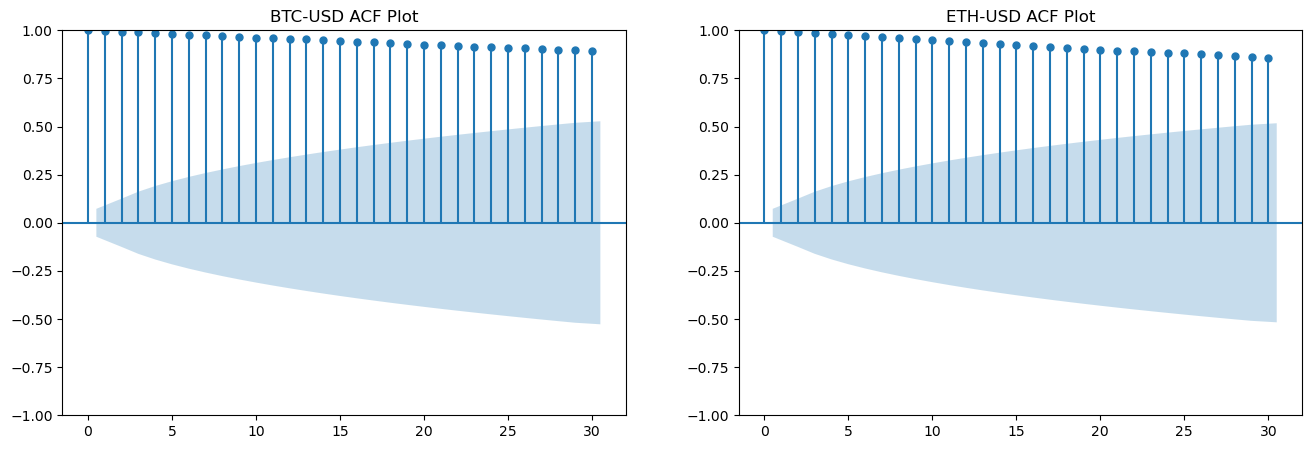

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

btc_data = data['Adj Close']['BTC-USD']
sm.graphics.tsa.plot_acf(btc_data.values.squeeze(), lags=30, ax=ax1, title="BTC-USD ACF Plot")

eth_data = data['Adj Close']['ETH-USD']
sm.graphics.tsa.plot_acf(eth_data.values.squeeze(), lags=30, ax=ax2, title="ETH-USD ACF Plot")
plt.show()

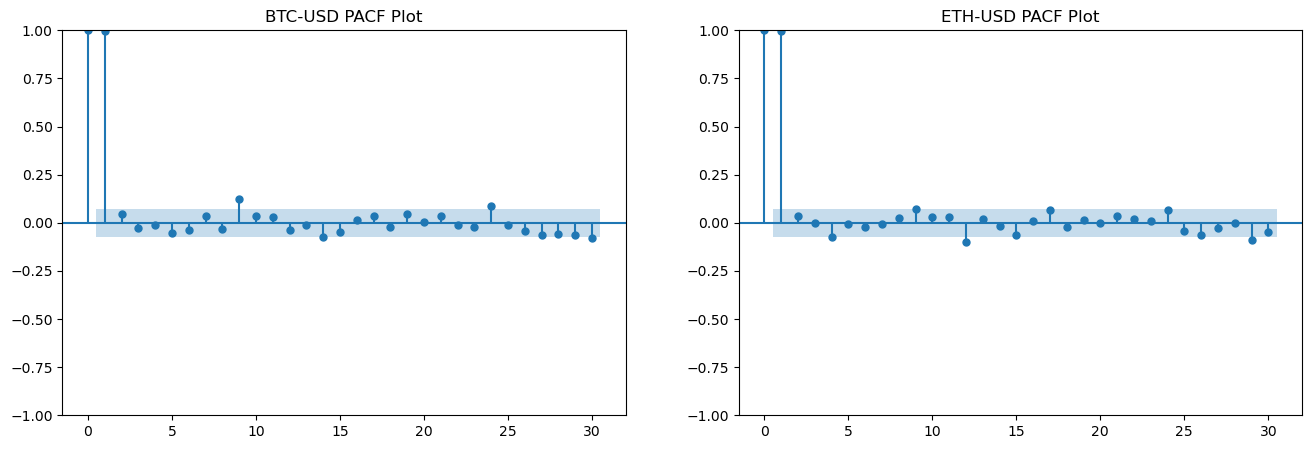

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

btc_data = data['Adj Close']['BTC-USD']
sm.graphics.tsa.plot_pacf(btc_data.values.squeeze(), lags=30, ax=ax1, title="BTC-USD PACF Plot")

eth_data = data['Adj Close']['ETH-USD']
sm.graphics.tsa.plot_pacf(eth_data.values.squeeze(), lags=30, ax=ax2, title="ETH-USD PACF Plot")
plt.show()

The plot shows significant autocorrelation, the previous value of the currenty determines days closing price. From the PACF plot it is clear that price of certain period of time is correlated than others, say for example price on day 4, 9, 12, 15 etc.

In the next sections we will check for Autocorrelatioins and Partial Autocorrelations for Volume in both crypto currencies.

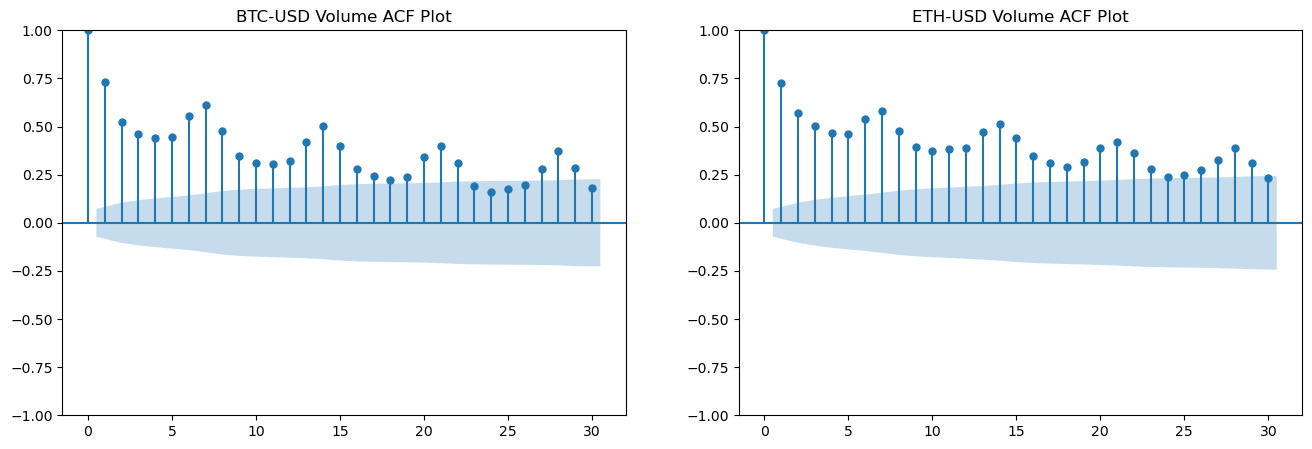

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

btc_data = data['Volume']['BTC-USD']
sm.graphics.tsa.plot_acf(btc_data.values.squeeze(), lags=30, ax=ax1, title="BTC-USD Volume ACF Plot")

eth_data = data['Volume']['ETH-USD']
sm.graphics.tsa.plot_acf(eth_data.values.squeeze(), lags=30, ax=ax2, title="ETH-USD Volume ACF Plot")
plt.show()

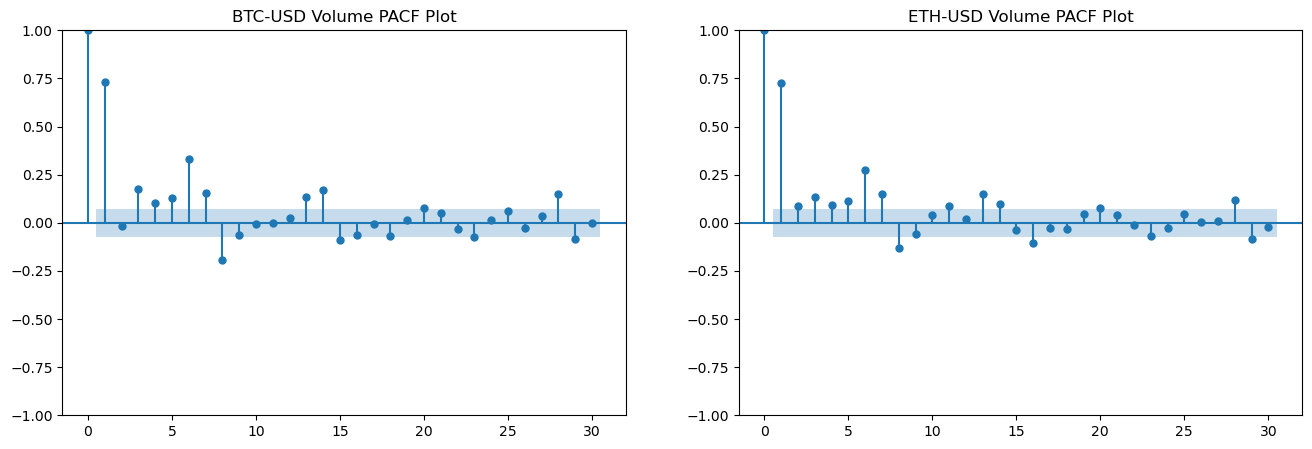

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

btc_data = data['Volume']['BTC-USD']
sm.graphics.tsa.plot_pacf(btc_data.values.squeeze(), lags=30, ax=ax1, title="BTC-USD Volume PACF Plot")

eth_data = data['Volume']['ETH-USD']
sm.graphics.tsa.plot_pacf(eth_data.values.squeeze(), lags=30, ax=ax2, title="ETH-USD Volume PACF Plot")
plt.show()

### **Statistical Test for Stationarity**

In this section we will use ADF test to establish that dataset is stationary. It is a unit-root test for time series.



In [111]:
from statsmodels.tsa.stattools import adfuller

print("P-value for AD Fuller test for BTC-USD Adj Close {}".format(adfuller( data['Adj Close']['BTC-USD'])[1]))
print("P-value for AD Fuller test for ETH-USD Adj Close {}".format(adfuller( data['Adj Close']['ETH-USD'])[1]))
print("P-value for AD Fuller test for BTC-USD Volume {}".format(adfuller( data['Volume']['BTC-USD'])[1]))
print("P-value for AD Fuller test for ETH-USD Volume {}".format(adfuller( data['Volume']['ETH-USD'])[1]))

P-value for AD Fuller test for BTC-USD Adj Close 0.8759619045006749
P-value for AD Fuller test for ETH-USD Adj Close 0.6087041759596572
P-value for AD Fuller test for BTC-USD Volume 0.011305878023385875
P-value for AD Fuller test for ETH-USD Volume 0.02339000739363443


From the AD Fuller test, it can be seen for Adj Close Price the p-value is greater than 0.05 for ETH-USD and BTC-USD, indicating the data series is non-stationary.

In the case of Volume the p-value is less than 0.05, therefore wwe reject the null hypotheis and conclude that the series is stationary. We will see this idea elaborated with Kalman Forecast below for Volume, they do no show any trend.

# **Exploring Kalman Filter**

Getting started with Kalman Filters for the data, we will be using the algorithms implementation in pykalman. Let us do the Kalman smoothing and filtering methods to remove the trend here. Stock price by nature is very noisy and with an underlying trend. The identification of this trend can be useful in many ways and can also be used as a feature for stock price forecasting using ARIMA, Linear Regression or any other methods.

#### **Understanding the Hyperparameters of Kalman Filters**
In this notebook we will using the Kalman Filter class to forecast the time series. There is only one signal wich is the "Adj Close Price" and "Volume" and
these parameters can be optimized before calling *filter* or *em* function.

*  transition_matrices - It is an identity matrix, default value is [1]
*  observation_matrices - It is an identity matrix, default value is [1]
*  initial_state_mean - We can use the mean value of the series, we can keep it 0
*  initial_state_covariance - We are keeping it as 1
*  observation_covariance - obseration noise, Default value is 1
*  transition_covariance - Parameter controls the noise, lower the value lower the noise during the transition to new state. Higher values may cause overfitting.

In [115]:
# initializing kalman filters

from pykalman import KalmanFilter
import numpy as np


kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

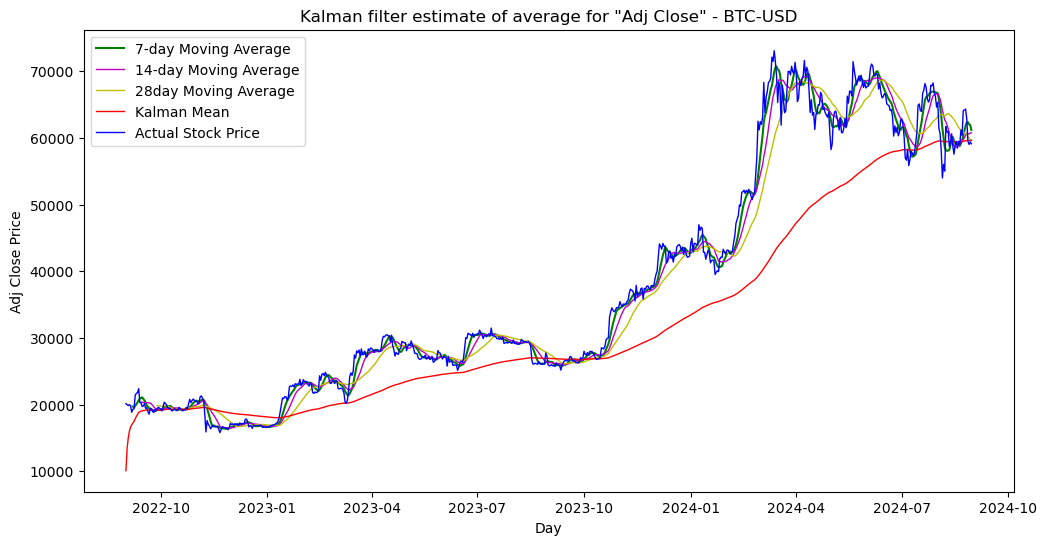

In [116]:
# using Kalman Filters for BTC-USD

stock_price = data['Adj Close']['BTC-USD']
mean, cov = kalmanFilter.filter(stock_price)
kalman_mean = pd.Series(mean.flatten(), index=stock_price.index)



rolling_3d = stock_price.rolling(window=3).mean()
rolling_7d = stock_price.rolling(window=7).mean()
rolling_14d = stock_price.rolling(window=14).mean()
rolling_28d = stock_price.rolling(window=28).mean()

plt.figure(figsize=(12,6))
plt.plot(rolling_7d,'-g',lw=1.5)
plt.plot(rolling_14d, 'm', lw=1)
plt.plot(rolling_28d, 'y', lw=1)
plt.plot(kalman_mean, 'r', lw=1)
plt.plot(stock_price, 'b', lw=1)
plt.title('Kalman filter estimate of average for "Adj Close" - BTC-USD')
plt.legend(['7-day Moving Average', '14-day Moving Average', '28day Moving Average', 'Kalman Mean', 'Actual Stock Price'])
plt.xlabel('Day')
plt.ylabel('Adj Close Price');

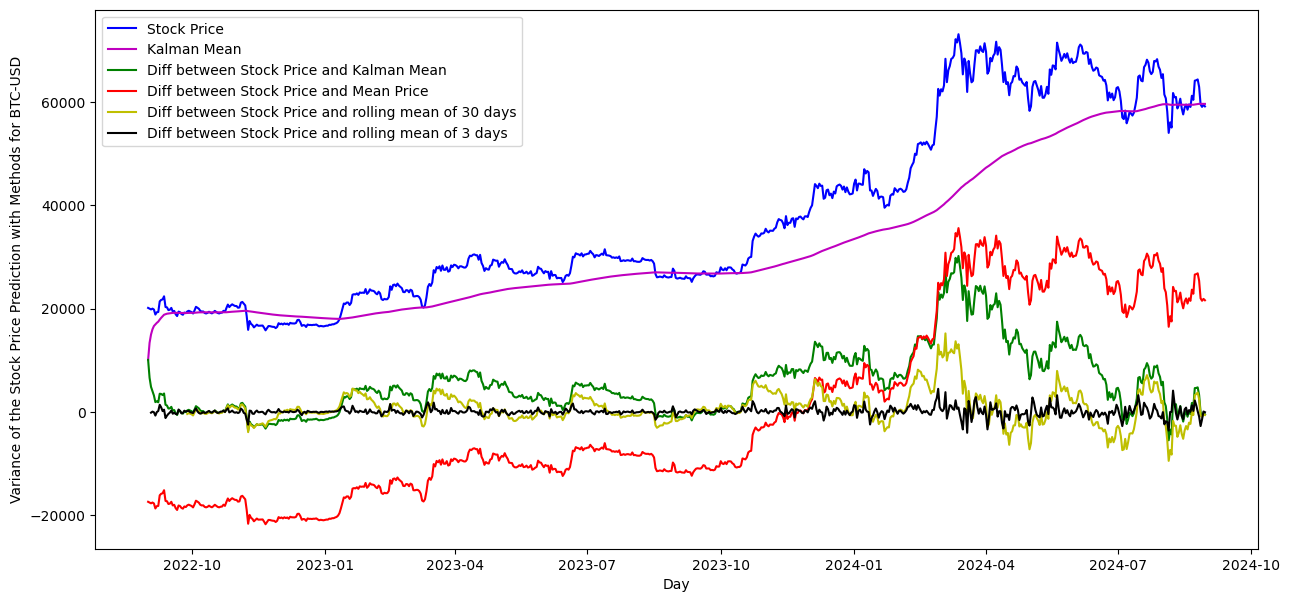

In [117]:
plt.figure(figsize=(15,7))
plt.plot(stock_price ,'b',lw=1.5)
plt.plot(kalman_mean ,'m',lw=1.5)
plt.plot(stock_price - kalman_mean,'-g',lw=1.5)
plt.plot(stock_price - stock_price.mean() ,'r',lw=1.5)
plt.plot(stock_price - rolling_28d ,'y',lw=1.5)
plt.plot(stock_price - rolling_3d ,'k',lw=1.5)
plt.legend(['Stock Price', 'Kalman Mean', 'Diff between Stock Price and Kalman Mean', 'Diff between Stock Price and Mean Price',
            'Diff between Stock Price and rolling mean of 30 days', 'Diff between Stock Price and rolling mean of 3 days'])
plt.xlabel('Day')
plt.ylabel('Variance of the Stock Price Prediction with Methods for BTC-USD');

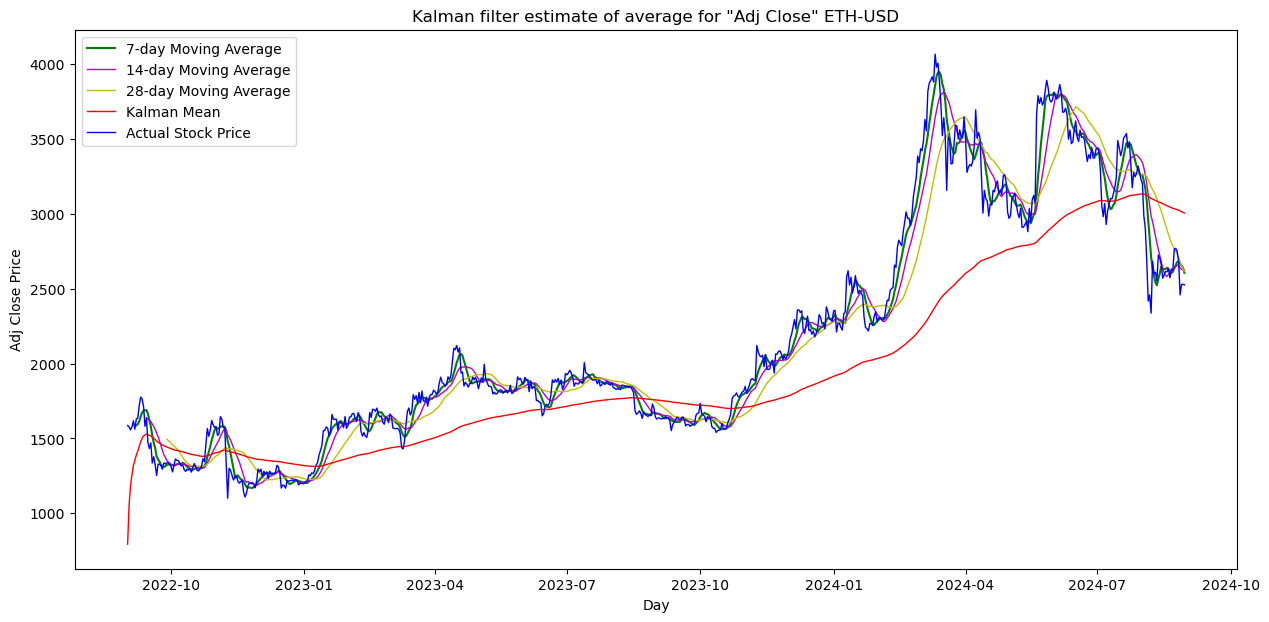

In [118]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)

stock_price = data['Adj Close']['ETH-USD']
mean, cov = kalmanFilter.filter(stock_price)
kalman_mean = pd.Series(mean.flatten(), index=stock_price.index)



rolling_3d = stock_price.rolling(window=3).mean()
rolling_7d = stock_price.rolling(window=7).mean()
rolling_14d = stock_price.rolling(window=14).mean()
rolling_28d = stock_price.rolling(window=28).mean()

plt.figure(figsize=(15,7))
plt.plot(rolling_7d,'-g',lw=1.5)
plt.plot(rolling_14d, 'm', lw=1)
plt.plot(rolling_28d, 'y', lw=1)
plt.plot(kalman_mean, 'r', lw=1)
plt.plot(stock_price, 'b', lw=1)
plt.title('Kalman filter estimate of average for "Adj Close" ETH-USD')
plt.legend(['7-day Moving Average', '14-day Moving Average', '28-day Moving Average', 'Kalman Mean', 'Actual Stock Price'])
plt.xlabel('Day')
plt.ylabel('Adj Close Price');

From the kalman Filter for Bitcoin it can be seen that it produces much more smooth signal than others and is more generalised than the rolling window prediction. Kalman fiklter helps in separating the noise from the signals and can be used for prediction

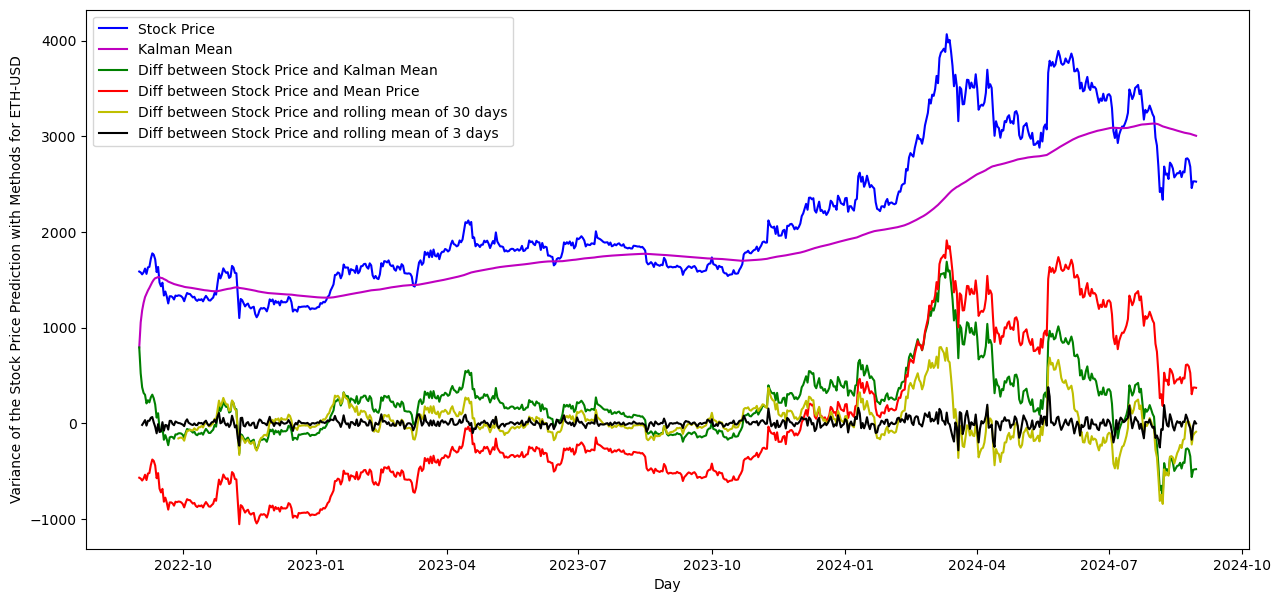

In [120]:
plt.figure(figsize=(15,7))
plt.plot(stock_price ,'b',lw=1.5)
plt.plot(kalman_mean ,'m',lw=1.5)
plt.plot(stock_price - kalman_mean,'-g',lw=1.5)
plt.plot(stock_price - stock_price.mean() ,'r',lw=1.5)
plt.plot(stock_price - rolling_28d ,'y',lw=1.5)
plt.plot(stock_price - rolling_3d ,'k',lw=1.5)

plt.legend(['Stock Price', 'Kalman Mean', 'Diff between Stock Price and Kalman Mean', 'Diff between Stock Price and Mean Price',  'Diff between Stock Price and rolling mean of 30 days',
            'Diff between Stock Price and rolling mean of 3 days'])
plt.xlabel('Day')
plt.ylabel('Variance of the Stock Price Prediction with Methods for ETH-USD');

Kalman Filters gives a time-evolving mean and shows fluctuations with time than the and difference stays closer to 0 compared to the other steps such as rolling mean and static mean. Such updated mean for each time point could help us manage aggressive trading strategies.

In the below section we will using Kalman Filter update method to do stock price forecasts for each day using the previous data as the prior and will keep on update the price on based on the daily available actual price like a dynamic system.

In the below Sections we will forecast Kalman Filter for **ETH-USD** and **BTC-USD** data for various time intervals. We will be using Kalman Filter update on 'Adj Close' column of the time series.In the later sections we will combine the prediction of both for our portfolio trading startegies using Vectorbt.

# **Kalman Filter for 'Adj Close Price' of ETH-USD**
In the below sections we will forecast 'Adj Close Price' for ETH-USD and compare our forecast values for different time intervals of 200, 100, 50 and 10 days. We will be using MAPE, $ R^2 $, MAE and RMSE values to validate our performance and compare it for different time periods.

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3486197673.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



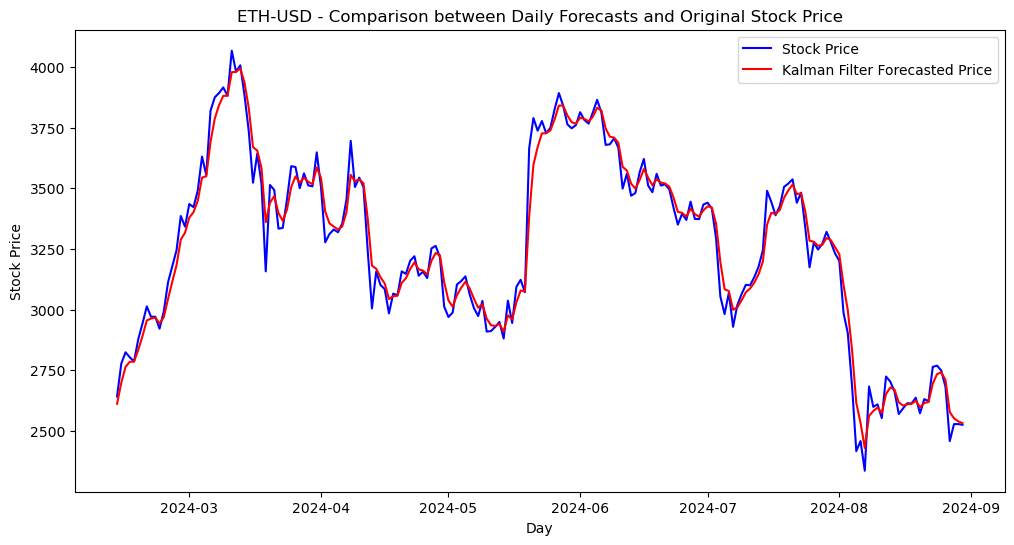

In [125]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.01)

# We keep the default parameters but set the transition_covariance to .01 to fit the noise

# Predicting for ETH-USD
stock_price = data['Adj Close']['ETH-USD']

# Kalman Forecast for Next 200 days
mean, cov = kalmanFilter.em(stock_price[:-200], n_iter=10).smooth(stock_price[:-200])
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(200):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, stock_price[-(200 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_price = pd.DataFrame(data=np.concatenate([stock_price[:-200].values, next_means]),
                  index=stock_price.index)

plt.figure(figsize=(12,6))
plt.plot(stock_price[len(stock_price)-200:] ,'b',lw=1.5)
plt.plot(forecasted_price[len(stock_price)-200:] ,'r',lw=1.5)
plt.legend(['Stock Price', 'Kalman Filter Forecasted Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('ETH-USD - Comparison between Daily Forecasts and Original Stock Price');

In [126]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_stock = stock_price[len(stock_price)-200:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_price[len(stock_price)-200:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_stock, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_stock, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_stock, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_stock, kalman_forecast_y)))

R square 0.9751798391850571
Mean absolute percentage error 0.013217189427143672
Root Mean Square Error RMSE 60.615140280576846
Mean absolute error 42.22231131160103


In [127]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.01)


# Predicting for ETH-USD
stock_price = data['Adj Close']['ETH-USD']

# Kalman Forecast for Next 100 days
mean, cov = kalmanFilter.em(stock_price[:-100], n_iter=10).smooth(stock_price[:-100]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(100):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, stock_price[-(100 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\2879373372.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



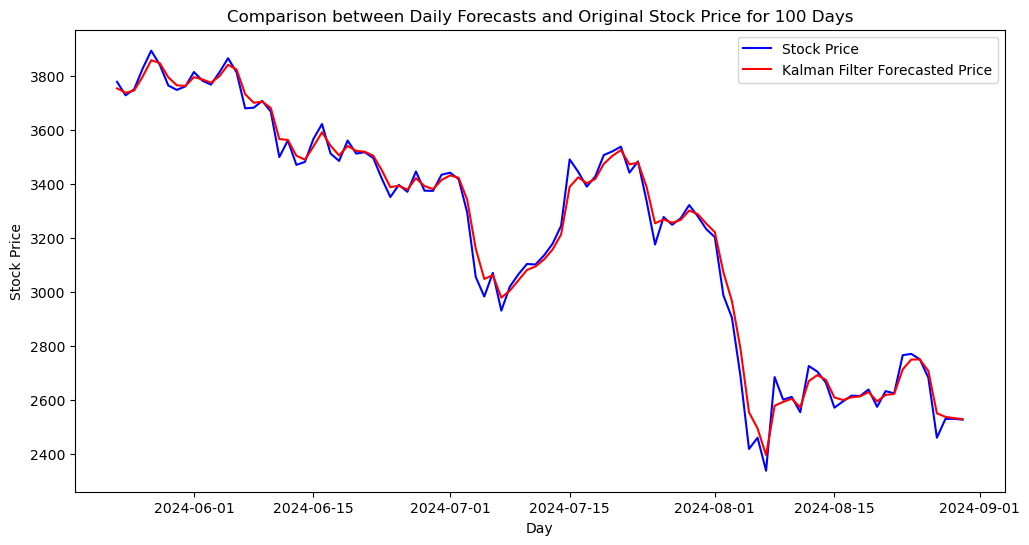

In [128]:
# replacing the forecasted price for the last 100 days
forecasted_price = pd.DataFrame(data=np.concatenate([stock_price[:-100].values, next_means]),
                  index=stock_price.index)

plt.figure(figsize=(12,6))
plt.plot(stock_price[len(stock_price)-100:] ,'b',lw=1.5)
plt.plot(forecasted_price[len(stock_price)-100:] ,'r',lw=1.5)
plt.legend(['Stock Price', 'Kalman Filter Forecasted Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price for 100 Days');

In [129]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_stock = stock_price[len(stock_price)-100:]
kalman_forecast_y = forecasted_price[len(stock_price)-100:]
print("R square {}".format(r2_score(_y_stock, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_stock, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_stock, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_stock, kalman_forecast_y)))

R square 0.9925009425356568
Mean absolute percentage error 0.00855730918420635
Root Mean Square Error RMSE 37.685854545900284
Mean absolute error 26.072913981998806


C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3929812125.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



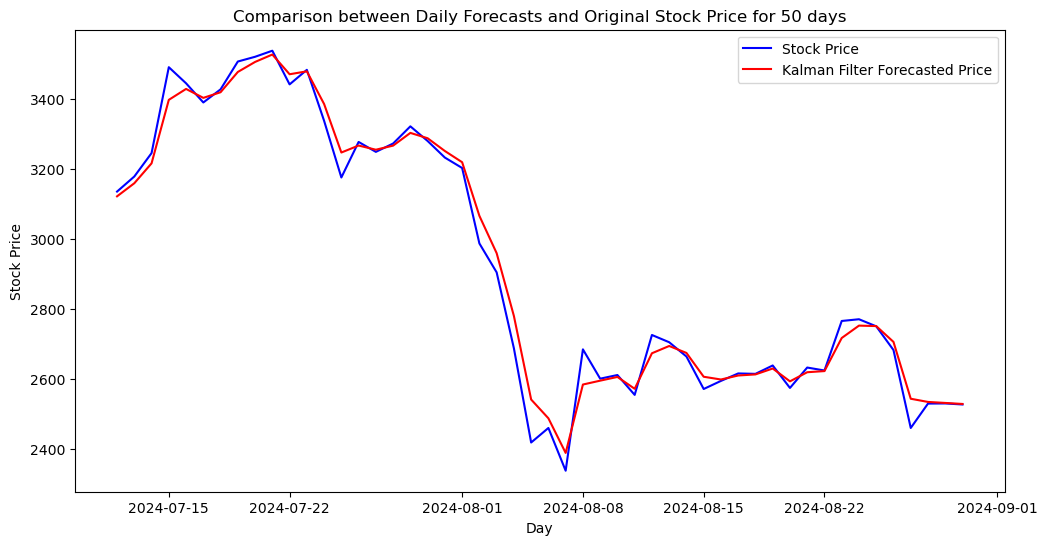

In [130]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.01)


# Predicting for ETH-USD
stock_price = data['Adj Close']['ETH-USD']

# Kalman Forecast for Next 50 days
mean, cov = kalmanFilter.em(stock_price[:-50], n_iter=10).smooth(stock_price[:-50])
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(50):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, stock_price[-(50 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_price = pd.DataFrame(data=np.concatenate([stock_price[:-50].values, next_means]),
                  index=stock_price.index)

plt.figure(figsize=(12,6))
plt.plot(stock_price[len(stock_price)-50:] ,'b',lw=1.5)
plt.plot(forecasted_price[len(stock_price)-50:] ,'r',lw=1.5)
plt.legend(['Stock Price', 'Kalman Filter Forecasted Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price for 50 days');

In [131]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_stock = stock_price[len(stock_price)-50:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_price[len(stock_price)-50:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_stock, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_stock, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_stock, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_stock, kalman_forecast_y)))

R square 0.9881729673527042
Mean absolute percentage error 0.009774608839587967
Root Mean Square Error RMSE 40.75238014572833
Mean absolute error 27.71636675367129


C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3810139589.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



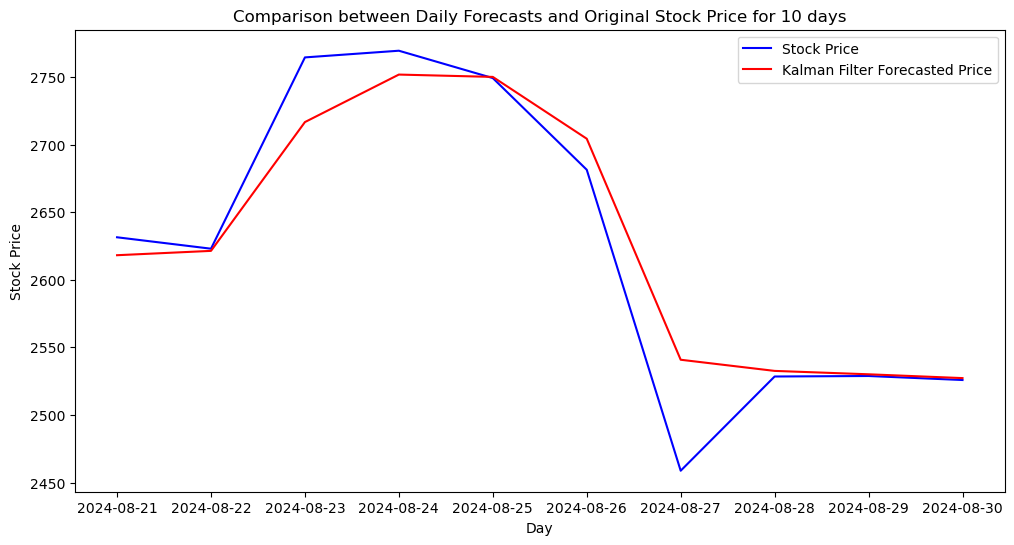

In [132]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.01)


# Predicting for ETH-USD
stock_price = data['Adj Close']['ETH-USD']

# Kalman Forecast for Next 100 days
mean, cov = kalmanFilter.em(stock_price[:-10], n_iter=10).smooth(stock_price[:-10]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(10):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, stock_price[-(10 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_price = pd.DataFrame(data=np.concatenate([stock_price[:-10].values, next_means]),
                  index=stock_price.index)

plt.figure(figsize=(12,6))
plt.plot(stock_price[len(stock_price)-10:] ,'b',lw=1.5)
plt.plot(forecasted_price[len(stock_price)-10:] ,'r',lw=1.5)
plt.legend(['Stock Price', 'Kalman Filter Forecasted Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price for 10 days');

In [133]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_stock = stock_price[len(stock_price)-10:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_price[len(stock_price)-10:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_stock, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_stock, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_stock, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_stock, kalman_forecast_y)))

R square 0.9124687521208008
Mean absolute percentage error 0.007428851406645756
Root Mean Square Error RMSE 31.72503430765914
Mean absolute error 19.307972955498645


# **Kalman Filter Forecast for Volume of ETH-USD**
Similar to the Adj Closing Price we will create a Kalam Filter for forecasting for ETH-USD for differerent time periods. We will be using forecast period of 200, 100, 50 and 10 days to compare the performance using the above mentioned metrics

In the below section we will forecast Volume for Ethereum data for 200 days

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3428375390.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



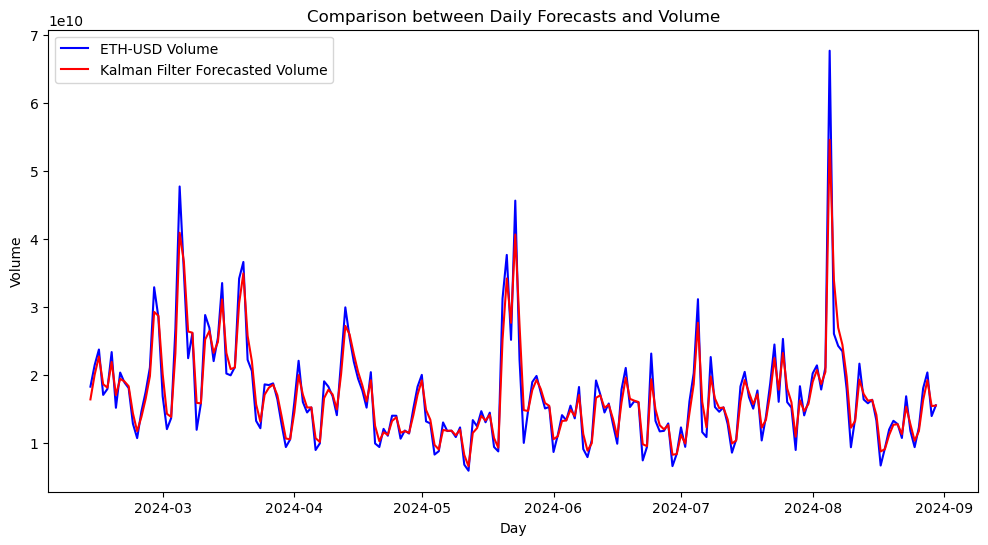

In [136]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=2)


# Predicting for ETH-USD
volume = data['Volume']['ETH-USD']

# Kalman Forecast for Next 100 days
mean, cov = kalmanFilter.em(volume[:-200], n_iter=10).smooth(volume[:-200]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(200):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, volume[-(200 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_volume = pd.DataFrame(data=np.concatenate([volume[:-200].values, next_means]),
                  index=volume.index)

plt.figure(figsize=(12,6))
plt.plot(volume[len(volume)-200:] ,'b',lw=1.5)
plt.plot(forecasted_volume[len(volume)-200:] ,'r',lw=1.5)
plt.legend(['ETH-USD Volume', 'Kalman Filter Forecasted Volume'])
plt.xlabel('Day')
plt.ylabel('Volume')
plt.title('Comparison between Daily Forecasts and Volume');

In [137]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_volume = volume[len(volume)-200:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_volume[len(volume)-200:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_volume, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_volume, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_volume, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_volume, kalman_forecast_y)))

R square 0.9286127908117351
Mean absolute percentage error 0.08178317315450043
Root Mean Square Error RMSE 2049202655.6268578
Mean absolute error 1374597299.8002546


C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\187236165.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



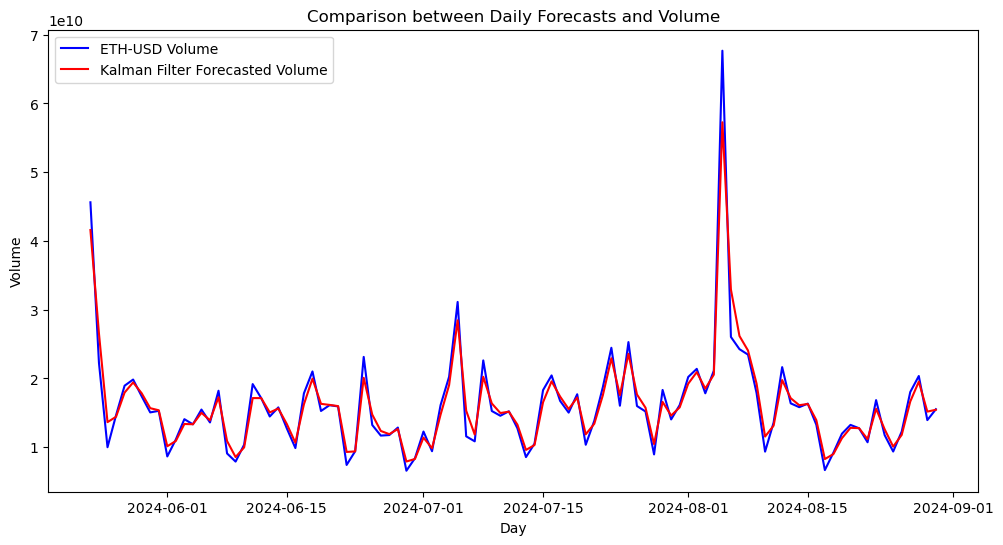

In [138]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=2)


# Predicting for ETH-USD
volume = data['Volume']['ETH-USD']

# Kalman Forecast for Next 100 days
mean, cov = kalmanFilter.em(volume[:-100], n_iter=10).smooth(volume[:-100]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(100):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, volume[-(100 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_volume = pd.DataFrame(data=np.concatenate([volume[:-100].values, next_means]),
                  index=volume.index)

plt.figure(figsize=(12,6))
plt.plot(volume[len(volume)-100:] ,'b',lw=1.5)
plt.plot(forecasted_volume[len(volume)-100:] ,'r',lw=1.5)
plt.legend(['ETH-USD Volume', 'Kalman Filter Forecasted Volume'])
plt.xlabel('Day')
plt.ylabel('Volume')
plt.title('Comparison between Daily Forecasts and Volume');

In [139]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_volume = volume[len(volume)-100:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_volume[len(volume)-100:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_volume, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_volume, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_volume, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_volume, kalman_forecast_y)))

R square 0.9436112773958336
Mean absolute percentage error 0.07167967220019686
Root Mean Square Error RMSE 1813420368.38731
Mean absolute error 1144993804.7182558


C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3235721145.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



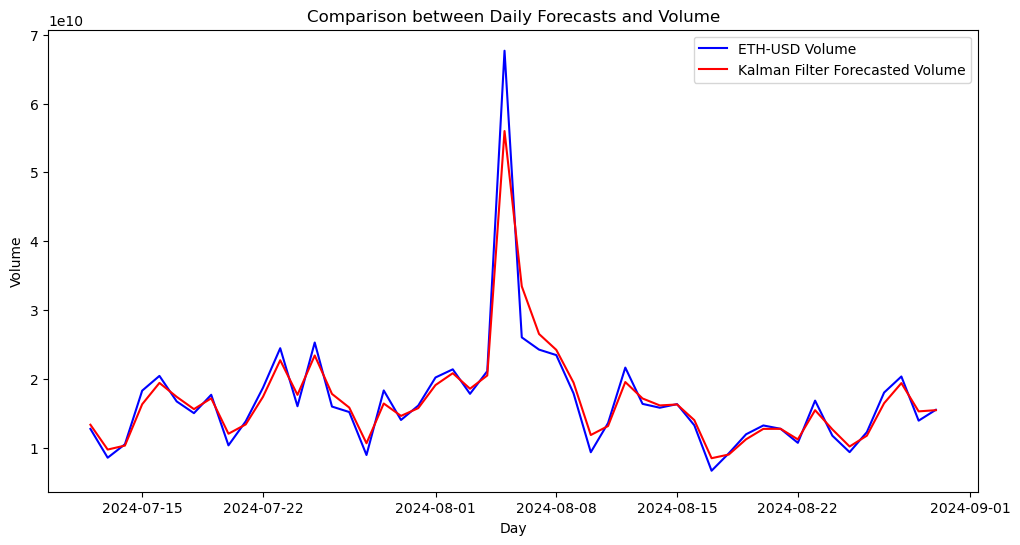

In [140]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=2)


# Predicting for ETH-USD
volume = data['Volume']['ETH-USD']

# Kalman Forecast for Next 100 days
mean, cov = kalmanFilter.em(volume[:-50], n_iter=10).smooth(volume[:-50]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(50):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, volume[-(50 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_volume = pd.DataFrame(data=np.concatenate([volume[:-50].values, next_means]),
                  index=volume.index)

plt.figure(figsize=(12,6))
plt.plot(volume[len(volume)-50:] ,'b',lw=1.5)
plt.plot(forecasted_volume[len(volume)-50:] ,'r',lw=1.5)
plt.legend(['ETH-USD Volume', 'Kalman Filter Forecasted Volume'])
plt.xlabel('Day')
plt.ylabel('Volume')
plt.title('Comparison between Daily Forecasts and Volume');

In [141]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_volume = volume[len(volume)-50:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_volume[len(volume)-50:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_volume, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_volume, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_volume, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_volume, kalman_forecast_y)))

R square 0.9299744480236641
Mean absolute percentage error 0.07609735466997161
Root Mean Square Error RMSE 2278519588.394209
Mean absolute error 1348608161.7600725


C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\181725885.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



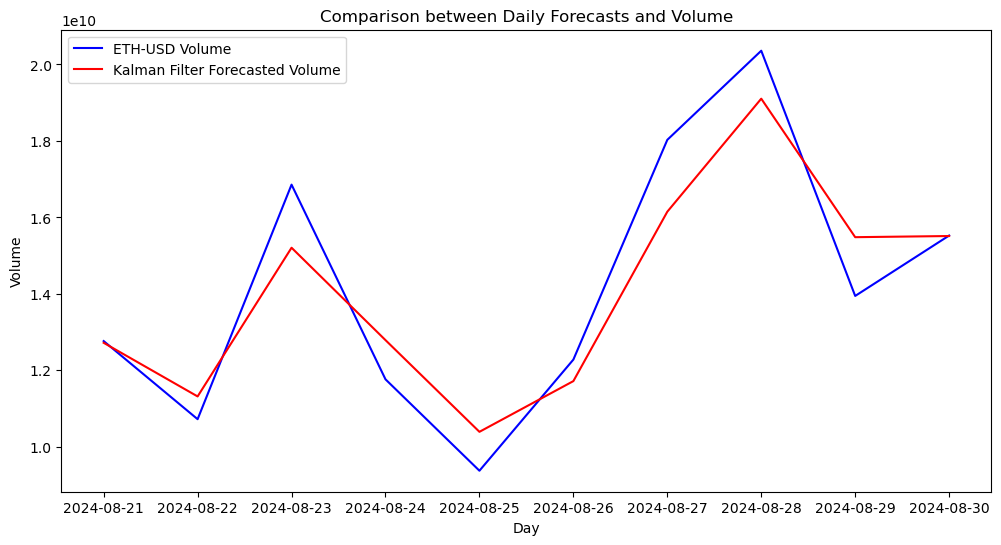

In [142]:
kalmanFilter = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=2)


# Predicting for ETH-USD
volume = data['Volume']['ETH-USD']

# Kalman Forecast for Next 10 days
mean, cov = kalmanFilter.em(volume[:-10], n_iter=10).smooth(volume[:-10]) # changed from 10 to 100, after experiment put it back to 10
# mean, cov = kalmanFilter.em(stock_price[1], n_iter=10)

next_means = []
next_covs = []
next_mean = mean[-1]
next_cov = cov[-1]
for i in range(10):
  next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, volume[-(10 - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
  next_means.append(next_mean[0])
  next_covs.append(next_cov[0])


# replacing the forecasted price for the last 10 days
forecasted_volume = pd.DataFrame(data=np.concatenate([volume[:-10].values, next_means]),
                  index=volume.index)

plt.figure(figsize=(12,6))
plt.plot(volume[len(volume)-10:] ,'b',lw=1.5)
plt.plot(forecasted_volume[len(volume)-10:] ,'r',lw=1.5)
plt.legend(['ETH-USD Volume', 'Kalman Filter Forecasted Volume'])
plt.xlabel('Day')
plt.ylabel('Volume')
plt.title('Comparison between Daily Forecasts and Volume');

In [143]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

_y_volume = volume[len(volume)-10:] # changed from 10 to 100, after experiment put it back to 10
kalman_forecast_y = forecasted_volume[len(volume)-10:] # changed from 10 to 100, after experiment put it back to 10
print("R square {}".format(r2_score(_y_volume, kalman_forecast_y)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(_y_volume, kalman_forecast_y)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(_y_volume, kalman_forecast_y))))
print("Mean absolute error {}".format(mean_absolute_error(_y_volume, kalman_forecast_y)))

R square 0.8806664540132818
Mean absolute percentage error 0.06751878127560942
Root Mean Square Error RMSE 1137850706.1595814
Mean absolute error 957798580.376063


# **Using Traditional ML for Prediction**

In this section we will explore how traditional methods work for stock price prediction. We will be using multivariable regression technique to predict closing price of the stock for the next day. The feature engineering for this model will include column values high, low, open, close, volume to determine the Adjusted close price for the next day.

In [146]:
data.head()

Price                         Adj Close                      Close  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2022-09-01 00:00:00+00:00  20127.140625  1586.176758  20127.140625   
2022-09-02 00:00:00+00:00  19969.771484  1577.220459  19969.771484   
2022-09-03 00:00:00+00:00  19832.087891  1556.872681  19832.087891   
2022-09-04 00:00:00+00:00  19986.712891  1577.641602  19986.712891   
2022-09-05 00:00:00+00:00  19812.371094  1617.183228  19812.371094   

Price                                           High               \
Ticker                         ETH-USD       BTC-USD      ETH-USD   
Date                                                                
2022-09-01 00:00:00+00:00  1586.176758  20198.390625  1593.082764   
2022-09-02 00:00:00+00:00  1577.220459  20401.568359  1643.183228   
2022-09-03 00:00:00+00:00  1556.872681  20037.009766  1579.454346   
2022-09-04 00:00:00+00:00  1577.641602  19999.689453  1578.009277   
2022-09-05 00:00:00+00:00  1617.183228  20031.160156  1621.661377   

Price                               Low                       Open  \
Ticker                          BTC-USD      ETH-USD       BTC-USD   
Date                                                                 
2022-09-01 00:00:00+00:00  19653.968750  1520.188354  20050.498047   
2022-09-02 00:00:00+00:00  19814.765625  1551.877930  20126.072266   
2022-09-03 00:00:00+00:00  19698.355469  1541.672119  19969.718750   
2022-09-04 00:00:00+00:00  19636.816406  1543.698853  19832.470703   
2022-09-05 00:00:00+00:00  19673.046875  1559.781860  19988.789062   

Price                                        Volume               
Ticker                         ETH-USD      BTC-USD      ETH-USD  
Date                                                              
2022-09-01 00:00:00+00:00  1553.756348  30182031010  16434276817  
2022-09-02 00:00:00+00:00  1586.017944  29123998928  17708478709  
2022-09-03 00:00:00+00:00  1577.213745  23613051457   9516825994  
2022-09-04 00:00:00+00:00  1556.895874  25245861652   8884144998  
2022-09-05 00:00:00+00:00  1577.884033  28813460025  13060541168

In [147]:
btc_data = {'Open': data['Open']['BTC-USD'],
            'Close': data['Close']['BTC-USD'],
            'High': data['High']['BTC-USD'],
            'Low': data['Low']['BTC-USD'],
            'Volume': data['Low']['BTC-USD'],
            'Adj Close': data['Adj Close']['BTC-USD']
            }

eth_data = {'Open': data['Open']['ETH-USD'],
            'Close': data['Close']['ETH-USD'],
            'High': data['High']['ETH-USD'],
            'Low': data['Low']['ETH-USD'],
            'Volume': data['Low']['ETH-USD'],
            'Adj Close': data['Adj Close']['ETH-USD']
            }

btc_df = pd.DataFrame(btc_data, columns = ['Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close'])
eth_df = pd.DataFrame(eth_data, columns = ['Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close'])

In [148]:
eth_df.head()

Open        Close         High          Low  \
Date                                                                            
2022-09-01 00:00:00+00:00  1553.756348  1586.176758  1593.082764  1520.188354   
2022-09-02 00:00:00+00:00  1586.017944  1577.220459  1643.183228  1551.877930   
2022-09-03 00:00:00+00:00  1577.213745  1556.872681  1579.454346  1541.672119   
2022-09-04 00:00:00+00:00  1556.895874  1577.641602  1578.009277  1543.698853   
2022-09-05 00:00:00+00:00  1577.884033  1617.183228  1621.661377  1559.781860   

                                Volume    Adj Close  
Date                                                 
2022-09-01 00:00:00+00:00  1520.188354  1586.176758  
2022-09-02 00:00:00+00:00  1551.877930  1577.220459  
2022-09-03 00:00:00+00:00  1541.672119  1556.872681  
2022-09-04 00:00:00+00:00  1543.698853  1577.641602  
2022-09-05 00:00:00+00:00  1559.781860  1617.183228

In [149]:
eth_df.describe()

Open        Close         High          Low       Volume  \
count   730.000000   730.000000   730.000000   730.000000   730.000000   
mean   2153.339377  2154.649833  2197.880829  2107.257615  2107.257615   
std     761.057358   760.858790   781.196683   736.665024   736.665024   
min    1100.107178  1100.169800  1136.442627  1081.138184  1081.138184   
25%    1617.854645  1620.496521  1644.864014  1580.678528  1580.678528   
50%    1865.844604  1866.100159  1887.949524  1845.784241  1845.784241   
75%    2640.590576  2640.965576  2709.429199  2585.498413  2585.498413   
max    4066.690430  4066.445068  4092.284180  3936.627197  3936.627197   

         Adj Close  
count   730.000000  
mean   2154.649833  
std     760.858790  
min    1100.169800  
25%    1620.496521  
50%    1866.100159  
75%    2640.965576  
max    4066.445068

In [150]:
btc_df.describe()

Open         Close          High           Low        Volume  \
count    730.000000    730.000000    730.000000    730.000000    730.000000   
mean   37464.146091  37518.319863  38162.137949  36780.942348  36780.942348   
std    17678.426052  17685.270401  18083.910703  17220.739292  17220.739292   
min    15782.300781  15787.284180  16253.047852  15599.046875  15599.046875   
25%    23627.717285  23665.855469  24119.581543  23253.754883  23253.754883   
50%    29403.917969  29412.204102  29845.836914  29113.966797  29113.966797   
75%    55644.687500  55988.014648  57679.622070  54234.083008  54234.083008   
max    73079.375000  73083.500000  73750.070312  71334.093750  71334.093750   

          Adj Close  
count    730.000000  
mean   37518.319863  
std    17685.270401  
min    15787.284180  
25%    23665.855469  
50%    29412.204102  
75%    55988.014648  
max    73083.500000

In [151]:
btc_df.head()

Open         Close          High  \
Date                                                                  
2022-09-01 00:00:00+00:00  20050.498047  20127.140625  20198.390625   
2022-09-02 00:00:00+00:00  20126.072266  19969.771484  20401.568359   
2022-09-03 00:00:00+00:00  19969.718750  19832.087891  20037.009766   
2022-09-04 00:00:00+00:00  19832.470703  19986.712891  19999.689453   
2022-09-05 00:00:00+00:00  19988.789062  19812.371094  20031.160156   

                                    Low        Volume     Adj Close  
Date                                                                 
2022-09-01 00:00:00+00:00  19653.968750  19653.968750  20127.140625  
2022-09-02 00:00:00+00:00  19814.765625  19814.765625  19969.771484  
2022-09-03 00:00:00+00:00  19698.355469  19698.355469  19832.087891  
2022-09-04 00:00:00+00:00  19636.816406  19636.816406  19986.712891  
2022-09-05 00:00:00+00:00  19673.046875  19673.046875  19812.371094

In [152]:
eth_df['Target'] = eth_df['Adj Close'].shift(-1)
eth_df.dropna(inplace=True)
eth_df.head()

Open        Close         High          Low  \
Date                                                                            
2022-09-01 00:00:00+00:00  1553.756348  1586.176758  1593.082764  1520.188354   
2022-09-02 00:00:00+00:00  1586.017944  1577.220459  1643.183228  1551.877930   
2022-09-03 00:00:00+00:00  1577.213745  1556.872681  1579.454346  1541.672119   
2022-09-04 00:00:00+00:00  1556.895874  1577.641602  1578.009277  1543.698853   
2022-09-05 00:00:00+00:00  1577.884033  1617.183228  1621.661377  1559.781860   

                                Volume    Adj Close       Target  
Date                                                              
2022-09-01 00:00:00+00:00  1520.188354  1586.176758  1577.220459  
2022-09-02 00:00:00+00:00  1551.877930  1577.220459  1556.872681  
2022-09-03 00:00:00+00:00  1541.672119  1556.872681  1577.641602  
2022-09-04 00:00:00+00:00  1543.698853  1577.641602  1617.183228  
2022-09-05 00:00:00+00:00  1559.781860  1617.183228  1561.748535

In [153]:
eth_df.tail()

Open        Close         High          Low  \
Date                                                                            
2024-08-25 00:00:00+00:00  2769.098145  2749.157715  2793.012939  2736.088867   
2024-08-26 00:00:00+00:00  2749.247559  2681.340576  2763.004150  2668.886719   
2024-08-27 00:00:00+00:00  2681.622803  2458.726562  2700.152832  2401.175049   
2024-08-28 00:00:00+00:00  2458.904785  2528.415527  2553.820068  2422.293701   
2024-08-29 00:00:00+00:00  2528.362305  2528.792725  2595.977051  2507.502441   

                                Volume    Adj Close       Target  
Date                                                              
2024-08-25 00:00:00+00:00  2736.088867  2749.157715  2681.340576  
2024-08-26 00:00:00+00:00  2668.886719  2681.340576  2458.726562  
2024-08-27 00:00:00+00:00  2401.175049  2458.726562  2528.415527  
2024-08-28 00:00:00+00:00  2422.293701  2528.415527  2528.792725  
2024-08-29 00:00:00+00:00  2507.502441  2528.792725  2525.822021

We can define as the forecast set for the last 10 data points to compare with our Kalman Forecast.

In [155]:
forecast_set = eth_df[-200:] # validation set, we will keep the last 200 indices for forecast
training_set = eth_df[:-200] # The other we will be using for training

In [156]:
# forecast_set

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

X = training_set.drop('Target', axis=1)
y = training_set['Target']


# calling a standard scaler
standard_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = standard_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

score = lr.score(X_test, y_test)
print('The linear regression confidence is {}'.format(score))

The linear regression confidence is 0.8901272092118372


In [158]:
prediction = lr.predict(X_test)

In [159]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

print("R square {}".format(r2_score(y_test, prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(y_test, prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(y_test, prediction))))
print("Mean absolute error {}".format(mean_absolute_error(y_test, prediction)))

R square 0.8901272092118372
Mean absolute percentage error 0.020487745711556763
Root Mean Square Error RMSE 65.69069264457511
Mean absolute error 46.307898146003694


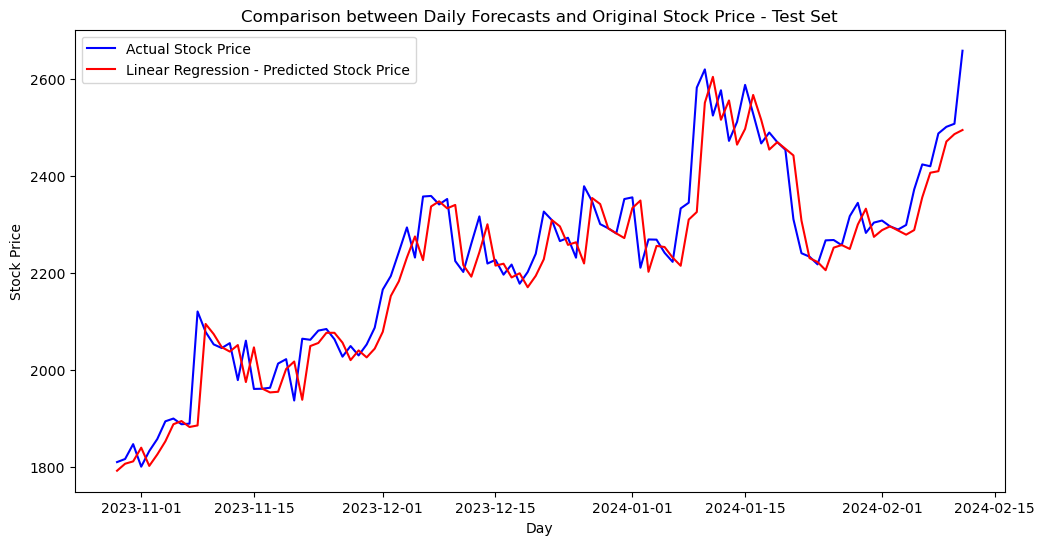

In [160]:
plt.figure(figsize=(12,6))
plt.plot(y_test ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=y_test.index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Test Set');

The forecast wilth test data has shown decent performance, let us check if the model holds the same performance for the forecast for validation set.

In [162]:
forecast_X = forecast_set.drop('Target', axis=1)
forecast_y = forecast_set['Target']
scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

prediction = lr.predict(scaled_forecast_X[:200])
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

print("R square {}".format(r2_score(forecast_y[:200], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:200], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:200], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:200], prediction)))

R square 0.9112548092283494
Mean absolute percentage error 0.02552535346021153
Root Mean Square Error RMSE 114.61757948704228
Mean absolute error 82.39452678453979


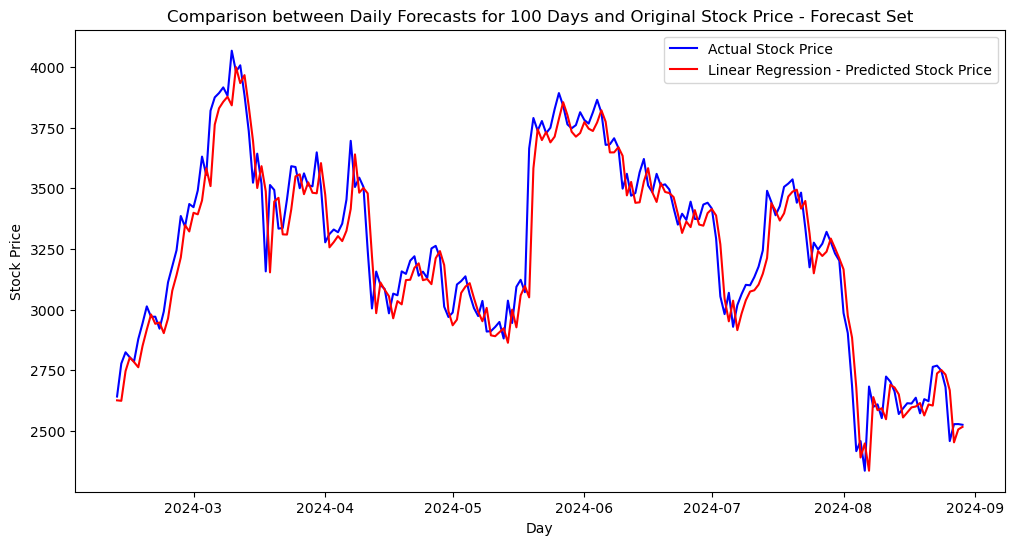

In [163]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:200] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:200].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts for 100 Days and Original Stock Price - Forecast Set');

In [164]:
prediction = lr.predict(scaled_forecast_X[:100])
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

print("R square {}".format(r2_score(forecast_y[:100], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:100], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:100], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:100], prediction)))

R square 0.8323551838429555
Mean absolute percentage error 0.02835664838233298
Root Mean Square Error RMSE 132.0883683204438
Mean absolute error 94.76701211020003


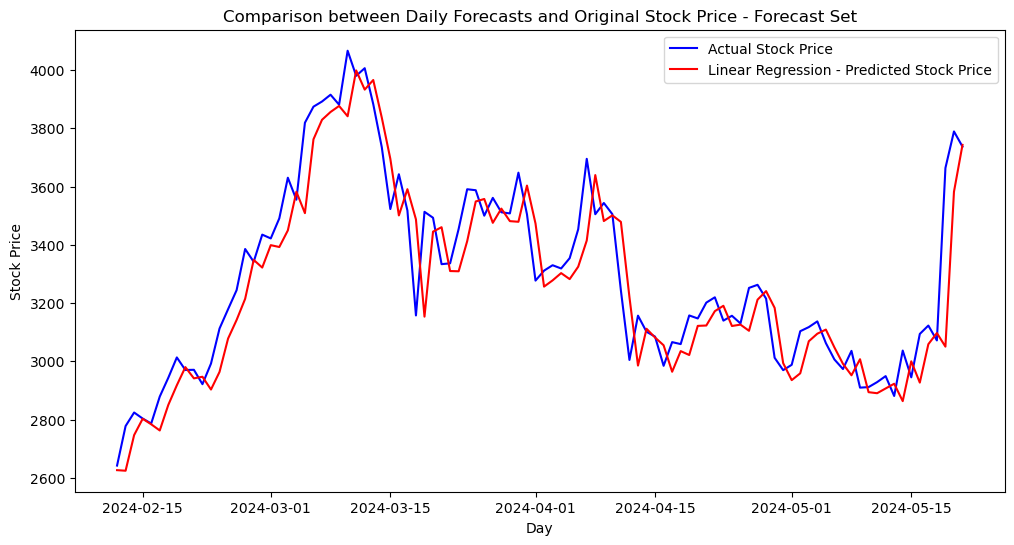

In [165]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:100] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:100].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

In [166]:
prediction = lr.predict(scaled_forecast_X[:50])
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

print("R square {}".format(r2_score(forecast_y[:50], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:50], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:50], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:50], prediction)))

R square 0.8739613109573533
Mean absolute percentage error 0.029339259487832624
Root Mean Square Error RMSE 129.9257058986771
Mean absolute error 100.33564495842678


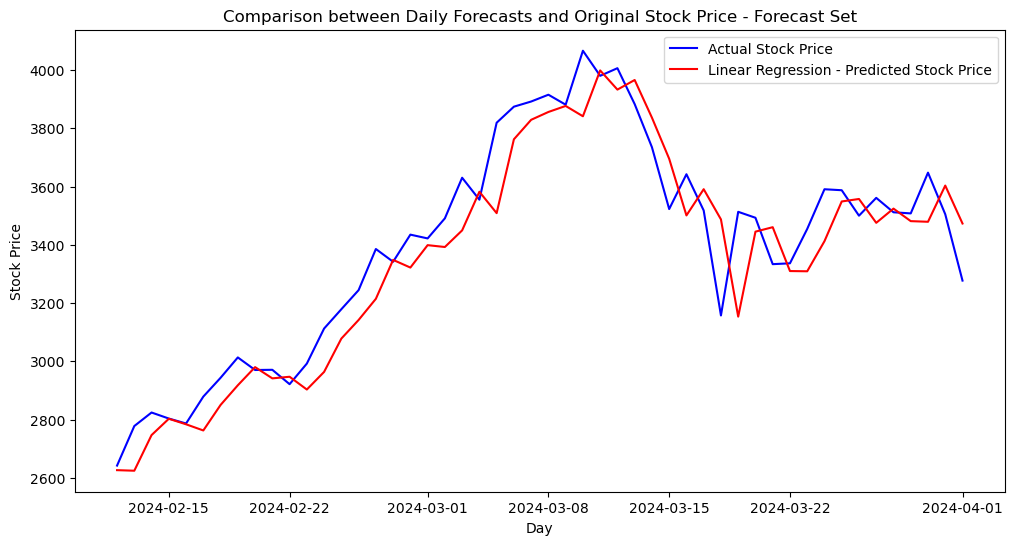

In [167]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:50] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:50].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

Metrics from LR for the stock price

In [169]:
prediction = lr.predict(scaled_forecast_X[:10])
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

print("R square {}".format(r2_score(forecast_y[:10], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:10], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:10], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:10], prediction)))

R square 0.48010947014208283
Mean absolute percentage error 0.020681800408457088
Root Mean Square Error RMSE 78.7858716152779
Mean absolute error 59.43540546040704


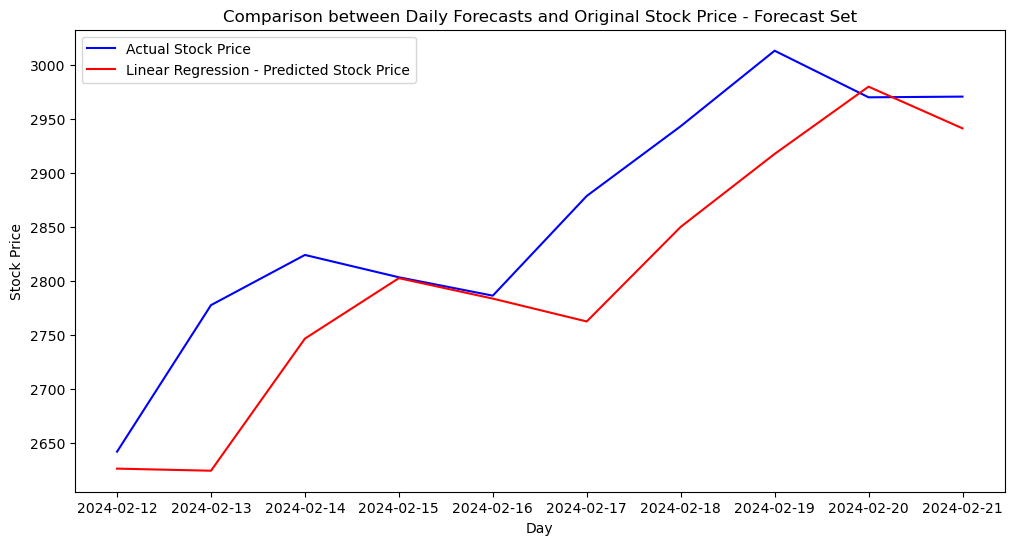

In [170]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:10] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:10].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

Let us do a forecast now for **BTC-USD** 'Adj Close Price' using Linear Regression model.

In [172]:
# process eth data

btc_df['Target'] = btc_df['Adj Close'].shift(-1)
btc_df.dropna(inplace=True)
btc_df.head()

# split into forecast and training data

forecast_set = btc_df[-200:] # validation set, we will keep the last 200 indices for forecast
training_set = btc_df[:-200] # The other we will be using for training

forecast_X = forecast_set.drop('Target', axis=1)
forecast_y = forecast_set['Target']

X = training_set.drop('Target', axis=1)
y = training_set['Target']


# calling a standard scaler
standard_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = standard_scaler.transform(X)

# X_scaled = preprocessing.scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

score = lr.score(X_test, y_test)
print('The linear regression confidence is {}'.format(score))

The linear regression confidence is 0.9173635656898157


In [173]:
from sklearn.metrics import r2_score , mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math

scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

prediction = lr.predict(scaled_forecast_X[:200])

print("R square {}".format(r2_score(forecast_y[:200], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:200], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:200], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:200], prediction)))

R square 0.8679898202175733
Mean absolute percentage error 0.021671412883848582
Root Mean Square Error RMSE 1874.731788755368
Mean absolute error 1376.42433879233


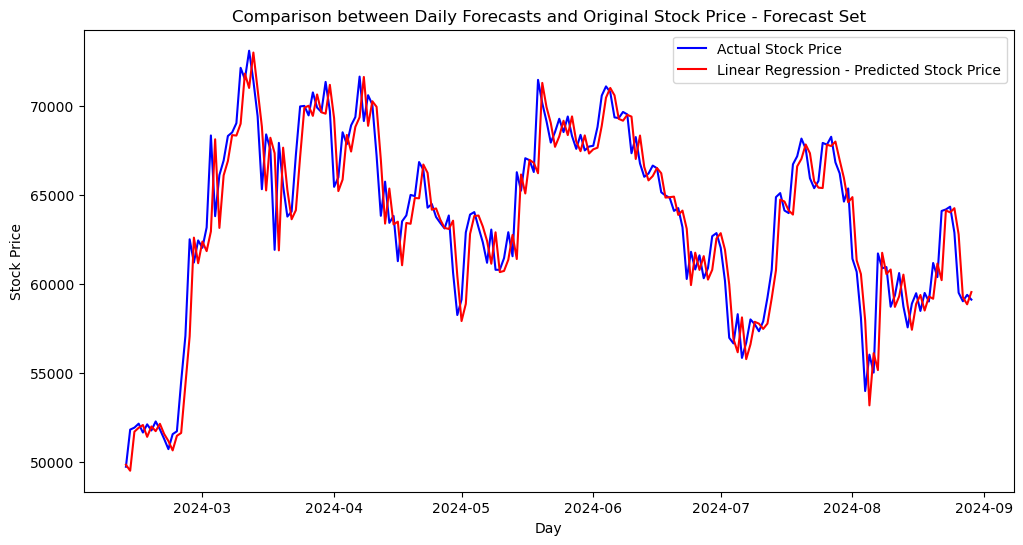

In [174]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:200] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:200].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

In [175]:
scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

prediction = lr.predict(scaled_forecast_X[:100])

print("R square {}".format(r2_score(forecast_y[:100], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:100], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:100], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:100], prediction)))

R square 0.8696243666921275
Mean absolute percentage error 0.024592651643961422
Root Mean Square Error RMSE 2127.7167194879758
Mean absolute error 1589.8310322598875


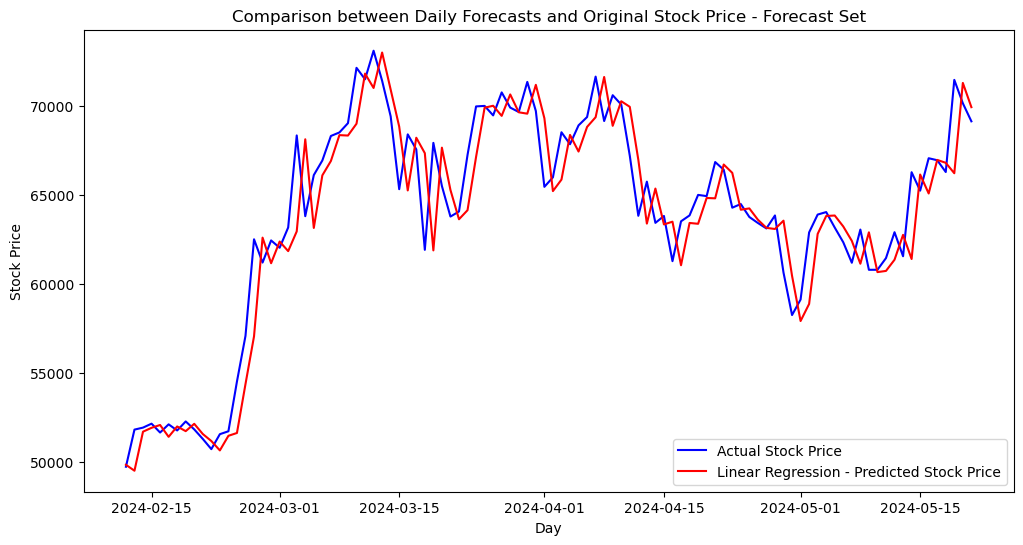

In [176]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:100] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:100].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

In [177]:
scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

prediction = lr.predict(scaled_forecast_X[:50])

print("R square {}".format(r2_score(forecast_y[:50], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:50], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:50], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:50], prediction)))


R square 0.9039253688688935
Mean absolute percentage error 0.02656147006237043
Root Mean Square Error RMSE 2336.57499467825
Mean absolute error 1706.5576641049656


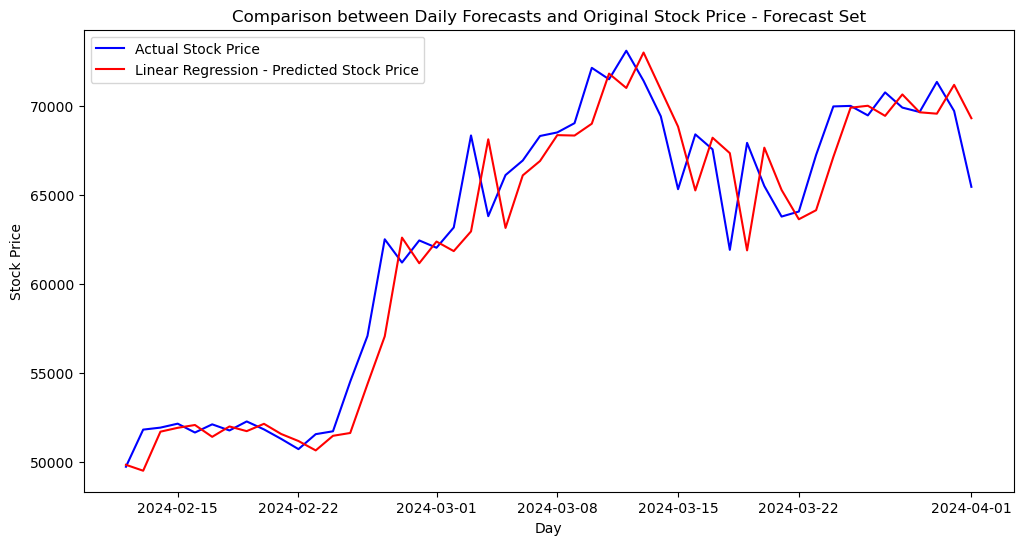

In [178]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:50] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:50].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

In [179]:
scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

prediction = lr.predict(scaled_forecast_X[:10])

print("R square {}".format(r2_score(forecast_y[:10], prediction)))
print("Mean absolute percentage error {}".format(mean_absolute_percentage_error(forecast_y[:10], prediction)))
print("Root Mean Square Error RMSE {}".format(math.sqrt(mean_squared_error(forecast_y[:10], prediction))))
print("Mean absolute error {}".format(mean_absolute_error(forecast_y[:10], prediction)))

R square -0.3780343532635413
Mean absolute percentage error 0.01033206529612266
Root Mean Square Error RMSE 814.0624699896028
Mean absolute error 535.6616842865384


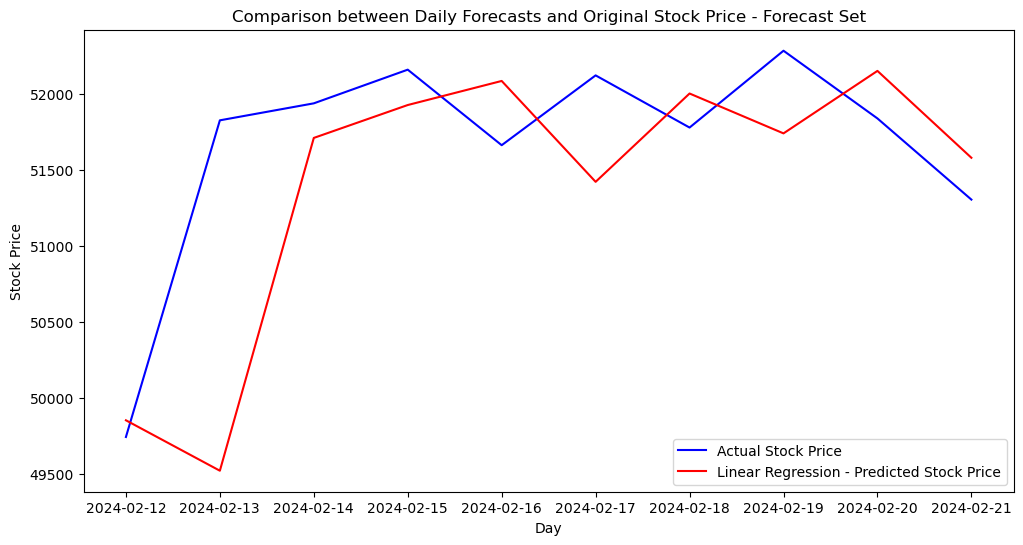

In [180]:
plt.figure(figsize=(12,6))
plt.plot(forecast_y[:10] ,'b',lw=1.5)
plt.plot(pd.DataFrame(data=prediction, index=forecast_y[:10].index) ,'r',lw=1.5)
plt.legend(['Actual Stock Price', 'Linear Regression - Predicted Stock Price'])
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.title('Comparison between Daily Forecasts and Original Stock Price - Forecast Set');

#  **Backtesting Forecasted Data - Ethereum and Bitcoin**

In this section we will backtest ETH-USD and BTC-USD using vectorbt. Vectorbt provides various methods for complex backtesting of the portfolios.

We will implement a backtesting strategy based on DMAC, which is Dual Moving Average Cross Over, as our entry and exit strategy. Vectorbt allows us to define entry and exit points of our strategy and compare indicators like sharpe ratio, treynor ratio etc evaluate the performance of our models.

We will be using the instances of fast MA greater that slow MA to enter or buy bitcoins and the opposite instances to exit the market.

In [182]:
import vectorbt as vbt

Below we define the Kalman forecast as a separate function modularized for predicting any stock price.


In [184]:
# defining Kalman Forecast for forecasting stock prices

def get_kalman_forecast(stock_price, index):

  # define Kalman Filter

  kalmanFilter = KalmanFilter(transition_matrices = [1],
                observation_matrices = [1],
                initial_state_mean = 0,
                initial_state_covariance = 1,
                observation_covariance=1,
                transition_covariance=.01)

  mean, cov = kalmanFilter.em(stock_price[:-index], n_iter=10).smooth(stock_price[:-index])

  next_means = []
  next_covs = []
  next_mean = mean[-1]
  next_cov = cov[-1]
  for i in range(index):
    next_mean, next_cov = kalmanFilter.filter_update(next_mean, next_cov, stock_price[-(index - i * 1)]) # changed from 10 to 100, after experiment put it back to 10
    next_means.append(next_mean[0])
    next_covs.append(next_cov[0])

  forecasted_price = pd.DataFrame(data=np.concatenate([stock_price[:-index].values, next_means]),
                    index=stock_price.index)

  return forecasted_price[len(stock_price)-index:]


# define forecast for Linear Regression
# this will train the model on data and predict on validation dataset

def get_lr_forecast(df, index):

  df['Target'] = df['Adj Close'].shift(-1)
  df.dropna(inplace=True)

  # split into forecast and training data

  forecast_set = df[-index:] # validation set, we will keep the last 200 indices for forecast
  training_set = df[:-index] # The other we will be using for training

  forecast_X = forecast_set.drop('Target', axis=1)
  forecast_y = forecast_set['Target']

  X = training_set.drop('Target', axis=1)
  y = training_set['Target']

  # calling a standard scaler
  standard_scaler = preprocessing.StandardScaler().fit(X)
  X_scaled = standard_scaler.transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)


  lr = LinearRegression(n_jobs=-1)
  lr.fit(X_train, y_train)

  scaled_forecast_X = standard_scaler.transform(forecast_X) # using the standard scaler from the training

  prediction = lr.predict(scaled_forecast_X)
  return prediction

In [185]:

# get the Kalman Forecasted Price

eth_data = eth_df['Adj Close']
eth_kalman_forecast = get_kalman_forecast(eth_data, 200)

btc_data = btc_df['Adj Close']
btc_kalman_forecast = get_kalman_forecast(btc_data, 200)


btc = list(x[0] for x in btc_kalman_forecast.values)
eth = list(x[0] for x in eth_kalman_forecast.values)
cdf = pd.DataFrame(data = {'BTC': btc, 'ETH': eth}, index= btc_kalman_forecast.index)
cdf.head()


# define backtesting strategy

def get_portfolio(df):
  fast_ma = vbt.MA.run(df, [1, 2], short_name="fast") # fast moving
  slow_ma = vbt.MA.run(df, [2, 3], short_name="slow")
  entries = fast_ma.ma_crossed_above(slow_ma)
  exits = slow_ma.ma_crossed_above(fast_ma)
  pf = vbt.Portfolio.from_signals(df, entries, exits, init_cash=100000)
  return pf


# calling the backtest on Kalman forecasted output for the portfolio

pf = get_portfolio(cdf)

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3259302421.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [186]:
pf.total_profit()

slow_window  fast_window     
2            1            BTC    54435.467834
                          ETH    87436.799399
3            2            BTC    53919.211118
                          ETH    72818.710265
Name: total_profit, dtype: float64

D:\Anaconda\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



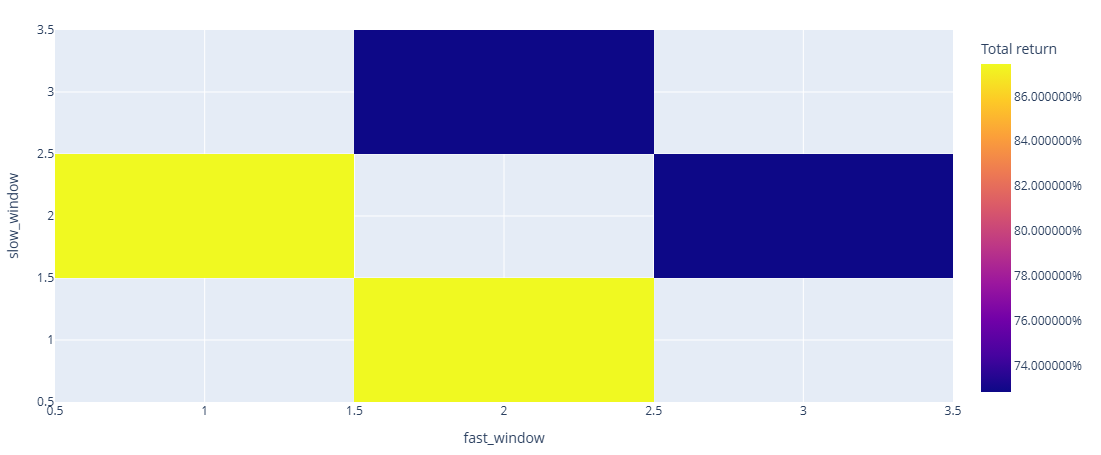

In [187]:
symbols = ["BTC", "ETH"]
fig = pf.total_return().vbt.heatmap(
    x_level='fast_window', y_level='slow_window',  symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()

In [188]:
pf.stats()

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3705677322.py:1: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001779B82F9C0>. Pass column to select a single column/group.



Start                         2024-02-12 00:00:00+00:00
End                           2024-08-29 00:00:00+00:00
Period                                200 days 00:00:00
Start Value                                    100000.0
End Value                                 167152.547154
Total Return [%]                              67.152547
Benchmark Return [%]                           9.460932
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               8.098127
Max Drawdown Duration                  47 days 06:00:00
Total Trades                                       31.5
Total Closed Trades                                31.5
Total Open Trades                                   0.0
Open Trade PnL                                      0.0
Win Rate [%]                                  46.629312
Best Trade [%]                                28.256176
Worst Trade [%]                               -4

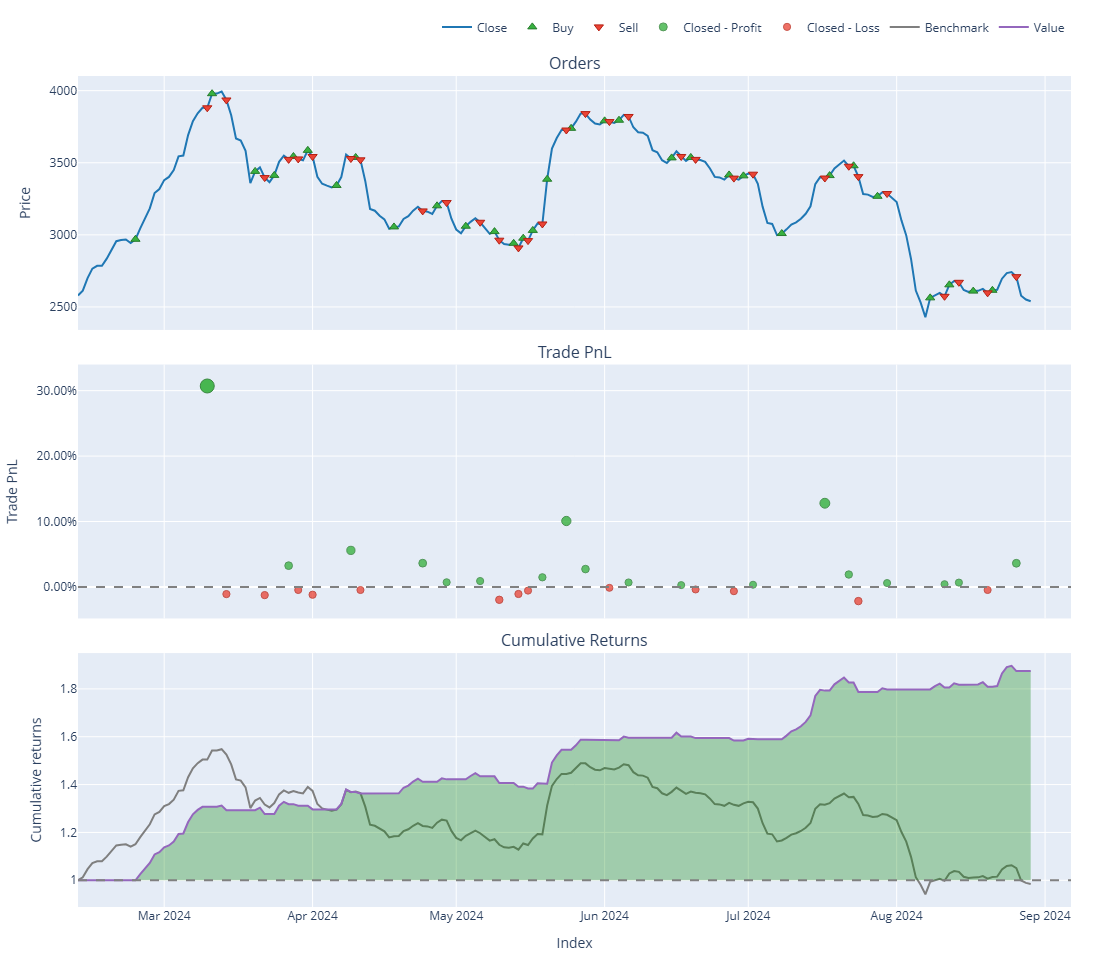

In [189]:
pf[(2, 1, 'ETH')].plots().show()

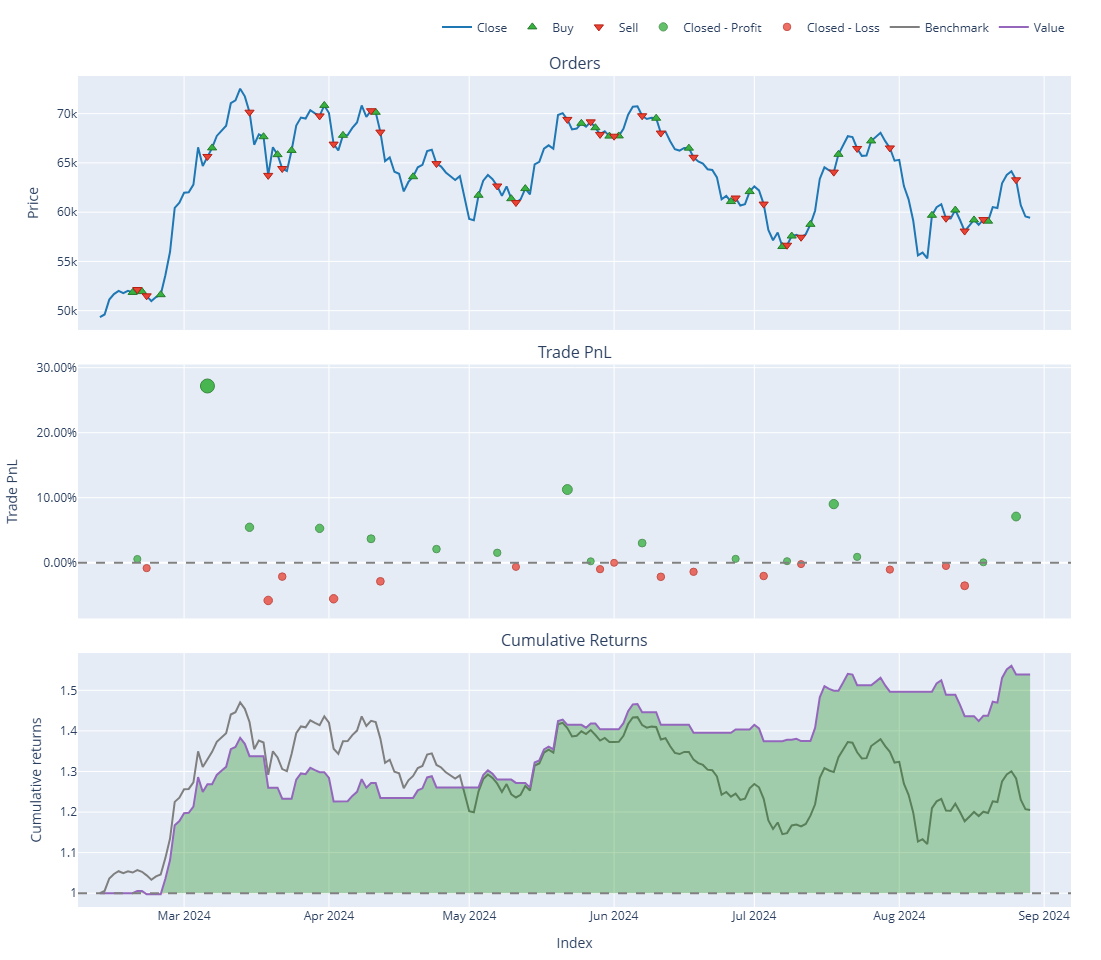

In [190]:
pf[(3, 2, 'BTC')].plots().show()

We call both BTC and ETH forecasted values, pf object returns total profit and other stats such as Omega ratio, Sortino ratio etc.

In [192]:
# get the Linear Regression Forecasted Price

eth_data = eth_df
eth_lr_forecast = get_lr_forecast(eth_data, 200)

btc_data = btc_df
btc_lr_forecast = get_lr_forecast(btc_data, 200)


btc =btc_lr_forecast.tolist()
eth = eth_lr_forecast.tolist()
cdf = pd.DataFrame(data = {'BTC': btc, 'ETH': eth}, index= eth_data[-200:].index)
cdf.head()


# calling backtesting lr output
pf = get_portfolio(cdf)
pf.total_profit()


slow_window  fast_window     
2            1            BTC   -10195.659388
                          ETH    -6116.601909
3            2            BTC    18490.892238
                          ETH    22249.466064
Name: total_profit, dtype: float64

In [193]:
pf.stats()

C:\Users\rakesh\AppData\Local\Temp\ipykernel_25192\3705677322.py:1: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001779B82F9C0>. Pass column to select a single column/group.



Start                         2024-02-11 00:00:00+00:00
End                           2024-08-28 00:00:00+00:00
Period                                200 days 00:00:00
Start Value                                    100000.0
End Value                                 106107.024251
Total Return [%]                               6.107024
Benchmark Return [%]                          11.253209
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              27.310194
Max Drawdown Duration                 163 days 00:00:00
Total Trades                                      46.75
Total Closed Trades                                46.5
Total Open Trades                                  0.25
Open Trade PnL                                      0.0
Win Rate [%]                                  37.979036
Best Trade [%]                                 20.65911
Worst Trade [%]                               -7

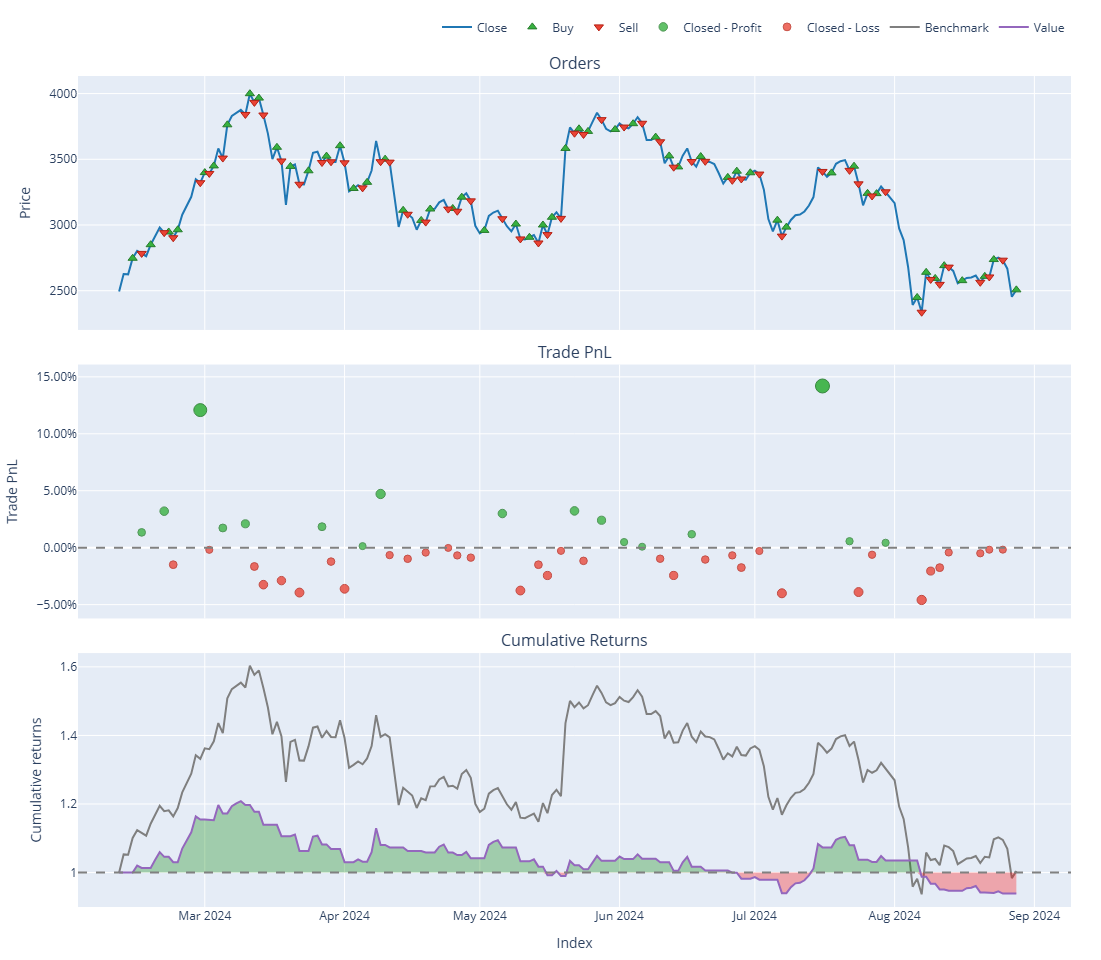

In [194]:
pf[(2, 1, 'ETH')].plots().show()

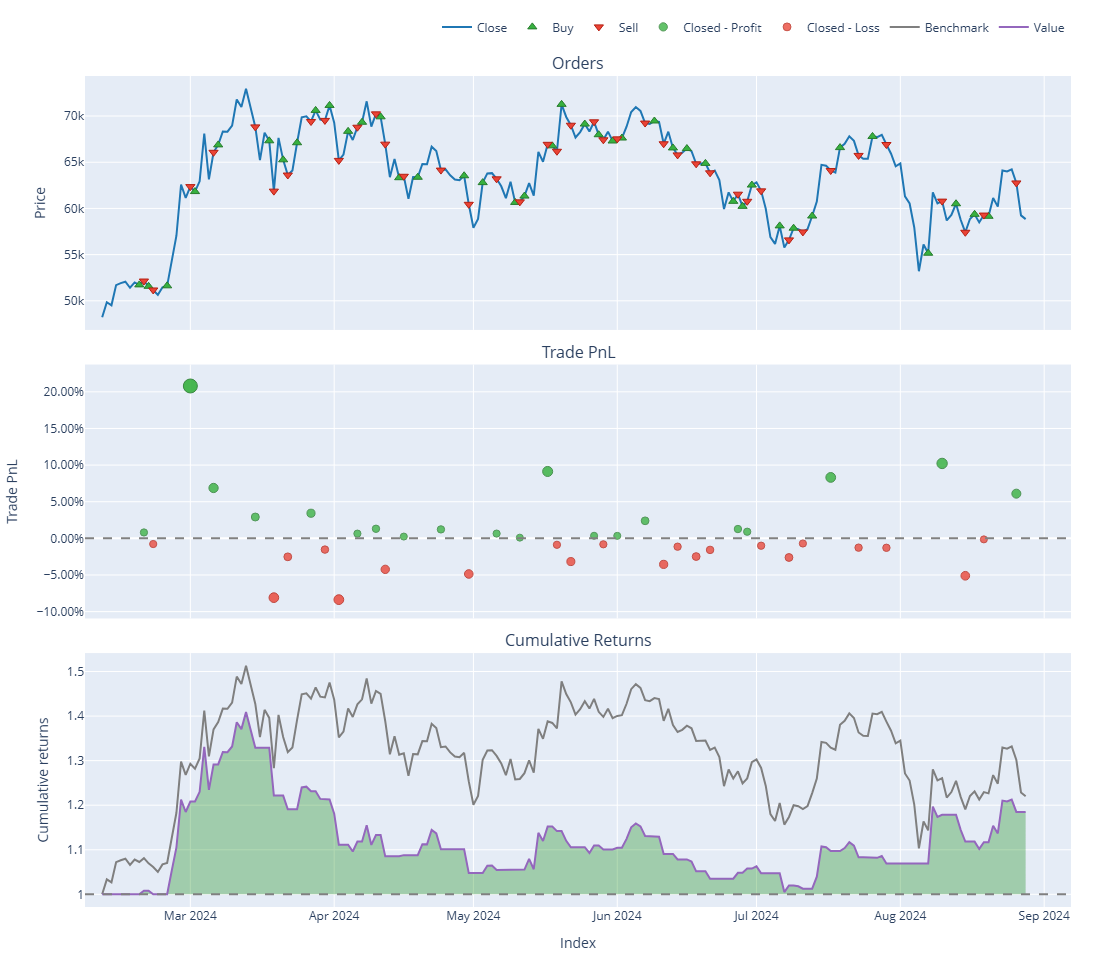

In [195]:
pf[(3, 2, 'BTC')].plots().show()